In [ ]:
!rm -rf /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip -q install -U "transformers>=4.44,<4.47" "accelerate>=0.33" "bitsandbytes>=0.43.3"

In [ ]:
pip -q uninstall -y torchvision


In [ ]:
pip -q install -U "transformers>=4.40.0" "accelerate>=0.30.0" "safetensors" -q


In [ ]:
"""
END-TO-END PIPELINE (one model at a time)
- Extract multi-depth embeddings for:
    (1) No-Prompt (article only)
    (2) Task-Article (prompt + article; pool ARTICLE span if found; else fallback to ALL tokens)
- Save:
    - embeddings .npy per depth/regime
    - per-sample stats .csv per model (includes fallback + truncation + OOM + lengths)
- After running all models:
    - aggregate stats into one CSV
    - print fallback rate summary (overall + by reason)
Designed to avoid reviewer nitpicks:
    - tokenizer-agnostic pooling (mask-aware mean pooling)
    - explicit article-span matching and fallback logging
    - consistent truncation policy (2048 tokens for representation extraction)
    - deterministic behavior and per-sample auditing
"""

import os, gc, json, re, math
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig


# ==============================
# 0) GLOBAL CONFIG
# ==============================
ROOT_DIR = "/content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity"
EXCEL_PATH = os.path.join(ROOT_DIR, "Dataset/fake_new_dataset.xlsx")

OUT_ROOT = os.path.join(ROOT_DIR, "Embeddings_MultiDepth_Run")
os.makedirs(OUT_ROOT, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE  = torch.bfloat16  # compute dtype; with 4-bit quant, compute dtype used by bnb config

MAX_TOKENS_REPR = 2048

# Relative depth ratios (token-agnostic across models)
DEPTH_RATIOS = {
    "early": 0.15,
    "mid_early": 0.35,
    "middle": 0.50,
    "mid_late": 0.70,
    "late": 0.90,
}

# Models to run (edit to your exact IDs)
MODELS = [
    ("tag_name", "hf_model_id", use_4bit)
    ("deepseek_distill_qwen_7b", "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B", True),
    ("qwen2_5_7b",               "Qwen/Qwen2.5-7B-Instruct",                True),
    ("deepseek_llm_7b_chat",     "deepseek-ai/deepseek-llm-7b-chat",        True),
    ("llama2_7b_chat",           "NousResearch/Llama-2-7b-chat-hf",            True),
    ("mistral_7b_instruct",      "unsloth/mixtral-8x7b-instruct-v0.1-bnb-4bit",       True),
    ("llama3_8b_instruct",       "unsloth/llama-3-8b-Instruct-bnb-4bit",      True),
    ("gpt_oss_20b",              "unsloth/gpt-oss-20b-bnb-4bit",True),
]


# ==============================
# 1) DATA
# ==============================
df_news = pd.read_excel(EXCEL_PATH).dropna(subset=["text"]).reset_index(drop=True)
texts   = df_news["text"].astype(str).tolist()
N       = len(texts)
print("Device:", DEVICE, "| N:", N)


# ==============================
# 2) HELPERS
# ==============================
def set_pad_token(tok):
    if tok.pad_token_id is None:
        if tok.eos_token_id is not None:
            tok.pad_token = tok.eos_token
        else:
            # rare case: no eos; create one
            tok.add_special_tokens({"pad_token": "[PAD]"})
    return tok

def get_depth_layer_indices(num_layers: int):
    """
    num_layers: number of transformer blocks (hidden_states has len=num_layers+1 with embeddings at 0)
    returns indices in hidden_states (1..num_layers)
    """
    idx = {}
    for name, r in DEPTH_RATIOS.items():
        layer_id = int(round(r * num_layers))
        layer_id = max(1, min(num_layers, layer_id))
        idx[name] = layer_id
    return idx

def find_subsequence(big: torch.Tensor, small: torch.Tensor):
    """
    Return (s, e) s.t. big[s:e] == small, else None.
    big/small are 1D CPU tensors.
    """
    if small.numel() == 0 or big.numel() < small.numel():
        return None
    starts = (big == small[0]).nonzero(as_tuple=False).flatten().tolist()
    for s in starts:
        e = s + small.numel()
        if e <= big.numel() and torch.equal(big[s:e], small):
            return (s, e)
    return None

def build_task_prompt(tokenizer, news_text: str):
    """
    Returns:
        full_text: system+user(with article)
        prefix_text: system+user(prefix only, no article)
    Prefer chat template if available, else raw strings.
    """
    system_msg = "You are a helpful assistant that writes concise, factual tweets summarizing news articles."
    user_prefix = (
        "Read the following news article and prepare to write ONE concise tweet (<=280 characters) "
        "that captures the key facts. Avoid hashtags, emojis, and mentions.\n\n"
        "News:\n"
    )

    # Try chat template
    try:
        if hasattr(tokenizer, "apply_chat_template") and getattr(tokenizer, "chat_template", None):
            full_text = tokenizer.apply_chat_template(
                [
                    {"role": "system", "content": system_msg},
                    {"role": "user",   "content": user_prefix + news_text},
                ],
                tokenize=False,
                add_generation_prompt=False,
            )
            prefix_text = tokenizer.apply_chat_template(
                [
                    {"role": "system", "content": system_msg},
                    {"role": "user",   "content": user_prefix},
                ],
                tokenize=False,
                add_generation_prompt=False,
            )
            return full_text, prefix_text
    except Exception:
        pass

    # Fallback plain text
    full_text = (
        f"{system_msg}\n\n"
        f"{user_prefix}{news_text}"
    )
    prefix_text = (
        f"{system_msg}\n\n"
        f"{user_prefix}"
    )
    return full_text, prefix_text

def safe_autocast():
    # On CPU autocast not needed
    if torch.cuda.is_available():
        return torch.autocast("cuda", dtype=DTYPE)
    # dummy context
    from contextlib import nullcontext
    return nullcontext()

def cleanup_model(model, tokenizer=None):
    try:
        del model
    except Exception:
        pass
    try:
        del tokenizer
    except Exception:
        pass
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


# ==============================
# 3) EMBEDDING EXTRACTORS
# ==============================
@torch.inference_mode()
def extract_noprompt_multidepth(model, tokenizer, text: str, max_tokens=MAX_TOKENS_REPR):
    """
    No-Prompt: encode article only.
    Pool = mask-aware mean pooling over all valid tokens.
    Returns: (vecs_dict, meta_dict)
    """
    tokenizer = set_pad_token(tokenizer)

    enc = tokenizer(
        text,
        return_tensors="pt",
        add_special_tokens=True,
        truncation=True,
        max_length=max_tokens,
    )
    ids  = enc["input_ids"].to(model.device, non_blocking=True)
    attn = enc["attention_mask"].to(model.device, non_blocking=True)

    # meta
    meta = {
        "mode": "noprompt",
        "truncated": bool(ids.shape[1] >= max_tokens),
        "seq_len": int(ids.shape[1]),
        "valid_tokens": int(attn.sum().item()),
    }

    with safe_autocast():
        out = model(input_ids=ids, attention_mask=attn, output_hidden_states=True, use_cache=False)

    hs = out.hidden_states  # tuple: [0]=emb, [1..]=blocks
    num_layers = len(hs) - 1
    depth_idx  = get_depth_layer_indices(num_layers)

    w = attn.squeeze(0).to(hs[1].dtype)  # [T]
    denom = w.sum().clamp(min=1)

    vecs = {}
    for name, lid in depth_idx.items():
        h = hs[lid].squeeze(0)  # [T,H]
        pooled = (h * w[:, None]).sum(0) / denom
        vecs[name] = pooled.float().cpu().numpy().astype(np.float32)

    # cleanup tensors
    del enc, ids, attn, out, hs, w
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    return vecs, meta


@torch.inference_mode()
def extract_taskarticle_multidepth(model, tokenizer, news_text: str, pool_mode="article", max_tokens=MAX_TOKENS_REPR):
    """
    Task-Article: system+instruction+article, but pool only ARTICLE span if possible.
    If span matching fails -> fallback to pooling ALL valid tokens.
    Returns: (vecs_dict, meta_dict)

    pool_mode:
        - "article": try article-only pooling, fallback to all if span not found
        - "all": pool all tokens always (useful diagnostic)
    """
    tokenizer = set_pad_token(tokenizer)

    full_text, prefix_text = build_task_prompt(tokenizer, news_text)

    # Tokenize full (prompt+article), with fixed truncation policy
    enc_full = tokenizer(
        full_text,
        return_tensors="pt",
        add_special_tokens=True,
        truncation=True,
        max_length=max_tokens,
    )
    full_ids  = enc_full["input_ids"].squeeze(0)      # [L]
    full_attn = enc_full["attention_mask"].squeeze(0) # [L]

    # Tokenize article alone (no special tokens) – also truncated to same budget for stable matching
    # NOTE: article-alone truncation is important: if full was truncated, the tail of article is missing.
    enc_art = tokenizer(
        news_text,
        return_tensors="pt",
        add_special_tokens=False,
        truncation=True,
        max_length=max_tokens,
    )
    art_ids = enc_art["input_ids"].squeeze(0)

    # Tokenize prefix alone (optional, for diagnostics)
    enc_prefix = tokenizer(
        prefix_text,
        return_tensors="pt",
        add_special_tokens=True,
        truncation=True,
        max_length=max_tokens,
    )
    prefix_len = int(enc_prefix["input_ids"].shape[1])

    # Build pooling mask
    full_mask = full_attn.float()
    pool_mask = full_mask.clone()

    span = None
    fallback_reason = "none"
    article_len_used = 0

    if pool_mode == "article" and art_ids.numel() > 0:
        span = find_subsequence(full_ids.cpu(), art_ids.cpu())
        if span is not None:
            s, e = span
            mask_art = torch.zeros_like(full_mask)
            mask_art[s:e] = 1.0
            pool_mask = mask_art * full_mask
            article_len_used = int(pool_mask.sum().item())
            if article_len_used < 1:
                pool_mask = full_mask
                fallback_reason = "empty_article_mask"
        else:
            pool_mask = full_mask
            fallback_reason = "span_not_found"
    elif pool_mode == "all":
        pool_mask = full_mask
        fallback_reason = "pool_all"
    else:
        pool_mask = full_mask
        fallback_reason = "no_article_tokens"

    # Forward pass
    ids  = full_ids.unsqueeze(0).to(model.device, non_blocking=True)
    attn = full_attn.unsqueeze(0).to(model.device, non_blocking=True)

    with safe_autocast():
        out = model(input_ids=ids, attention_mask=attn, output_hidden_states=True, use_cache=False)

    hs = out.hidden_states
    num_layers = len(hs) - 1
    depth_idx  = get_depth_layer_indices(num_layers)

    pm = pool_mask.to(hs[1].dtype).to(model.device)
    denom = pm.sum().clamp(min=1)

    vecs = {}
    for name, lid in depth_idx.items():
        h = hs[lid].squeeze(0)  # [L,H]
        pooled = (h * pm[:, None]).sum(0) / denom
        vecs[name] = pooled.float().cpu().numpy().astype(np.float32)

    meta = {
        "mode": "task_article",
        "pool_mode": pool_mode,
        "fallback": bool(fallback_reason not in ["none", "pool_all"]),
        "fallback_reason": fallback_reason,
        "span_found": bool(span is not None),
        "prefix_len_tokens": prefix_len,
        "full_len_tokens": int(full_ids.numel()),
        "valid_tokens_full": int(full_attn.sum().item()),
        "article_len_tokens_trunc": int(art_ids.numel()),
        "article_len_used_in_pool": int(article_len_used),
        "truncated_full": bool(full_ids.numel() >= max_tokens),
        "truncated_article_alone": bool(art_ids.numel() >= max_tokens),
    }

    # cleanup
    del enc_full, enc_art, enc_prefix
    del full_ids, full_attn, art_ids, prefix_len
    del ids, attn, out, hs, pm, full_mask, pool_mask
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    return vecs, meta


# ==============================
# 4) MODEL LOADING (4-bit option)
# ==============================
def load_model_and_tokenizer(model_id: str, use_4bit: bool):
    tok = AutoTokenizer.from_pretrained(model_id, use_fast=True, trust_remote_code=True)
    tok = set_pad_token(tok)

    quant_cfg = None
    if use_4bit:
        quant_cfg = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=DTYPE,
        )

    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        device_map="auto",
        trust_remote_code=True,
        torch_dtype=(DTYPE if not use_4bit else None),
        quantization_config=quant_cfg,
    )
    model.eval()
    if hasattr(model, "generation_config"):
        model.generation_config.use_cache = False
    return model, tok


# ==============================
# 5) RUN ONE MODEL (save npy + stats)
# ==============================
def run_one_model(tag: str, model_id: str, use_4bit: bool):
    out_dir = os.path.join(OUT_ROOT, tag)
    os.makedirs(out_dir, exist_ok=True)

    print(f"\n=============================\nRUN: {tag}\nMODEL: {model_id}\n4-bit: {use_4bit}\n=============================")

    model, tok = load_model_and_tokenizer(model_id, use_4bit)

    # probe hidden size + allocate arrays
    sample_vecs_np, _ = extract_noprompt_multidepth(model, tok, texts[0])
    hidden_size = sample_vecs_np["early"].shape[0]

    # storage dicts
    Z_np = {k: np.zeros((N, hidden_size), dtype=np.float32) for k in DEPTH_RATIOS}
    Z_ta = {k: np.zeros((N, hidden_size), dtype=np.float32) for k in DEPTH_RATIOS}

    # per-sample stats rows
    stats_rows = []

    def save_partial(step_i: int):
        # embeddings
        for k in DEPTH_RATIOS:
            np.save(os.path.join(out_dir, f"Z_{tag}_noprompt_{k}.npy"), Z_np[k])
            np.save(os.path.join(out_dir, f"Z_{tag}_task_article_{k}.npy"), Z_ta[k])
        # stats
        pd.DataFrame(stats_rows).to_csv(os.path.join(out_dir, f"stats_{tag}.csv"), index=False)
        # config snapshot
        with open(os.path.join(out_dir, f"config_{tag}.json"), "w") as f:
            json.dump({
                "tag": tag,
                "model_id": model_id,
                "use_4bit": use_4bit,
                "max_tokens_repr": MAX_TOKENS_REPR,
                "depth_ratios": DEPTH_RATIOS,
            }, f, indent=2)

        print(f"[autosave] i={step_i+1} saved embeddings+stats -> {out_dir}")

    # main loop
    for i in tqdm(range(N), desc=f"Embedding {tag}"):
        text = texts[i]

        row = {"i": i}
        # -------- No-Prompt --------
        try:
            vecs_np, meta_np = extract_noprompt_multidepth(model, tok, text)
            for k in DEPTH_RATIOS:
                Z_np[k][i] = vecs_np[k]
            row.update({
                "np_seq_len": meta_np["seq_len"],
                "np_valid_tokens": meta_np["valid_tokens"],
                "np_truncated": meta_np["truncated"],
                "np_oom": False,
            })
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                row["np_oom"] = True
            else:
                row["np_oom"] = True
            # zero vectors already default
            row.update({"np_seq_len": np.nan, "np_valid_tokens": np.nan, "np_truncated": np.nan})
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        # -------- Task-Article (article-only pooling w/ fallback) --------
        try:
            vecs_ta, meta_ta = extract_taskarticle_multidepth(model, tok, text, pool_mode="article")
            for k in DEPTH_RATIOS:
                Z_ta[k][i] = vecs_ta[k]
            row.update({
                "ta_full_len": meta_ta["full_len_tokens"],
                "ta_valid_full": meta_ta["valid_tokens_full"],
                "ta_prefix_len": meta_ta["prefix_len_tokens"],
                "ta_article_len_trunc": meta_ta["article_len_tokens_trunc"],
                "ta_article_len_used": meta_ta["article_len_used_in_pool"],
                "ta_span_found": meta_ta["span_found"],
                "ta_fallback": meta_ta["fallback"],
                "ta_fallback_reason": meta_ta["fallback_reason"],
                "ta_trunc_full": meta_ta["truncated_full"],
                "ta_trunc_article": meta_ta["truncated_article_alone"],
                "ta_oom": False,
            })
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                row["ta_oom"] = True
            else:
                row["ta_oom"] = True
            row.update({
                "ta_full_len": np.nan,
                "ta_valid_full": np.nan,
                "ta_prefix_len": np.nan,
                "ta_article_len_trunc": np.nan,
                "ta_article_len_used": np.nan,
                "ta_span_found": np.nan,
                "ta_fallback": np.nan,
                "ta_fallback_reason": "oom_or_error",
                "ta_trunc_full": np.nan,
                "ta_trunc_article": np.nan,
            })
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        stats_rows.append(row)

        # autosave
        if (i + 1) % 200 == 0:
            save_partial(i)

    # final save
    save_partial(N - 1)

    # cleanup model
    cleanup_model(model, tok)
    print(f"✅ Finished {tag}. Output in: {out_dir}")


# ==============================
# 6) RUN ALL MODELS
# ==============================
for tag, model_id, use_4bit in MODELS:
    run_one_model(tag, model_id, use_4bit)


# ==============================
# 7) AGGREGATE STATS ACROSS MODELS (for reporting)
# ==============================
all_rows = []
for tag, _, _ in MODELS:
    stats_path = os.path.join(OUT_ROOT, tag, f"stats_{tag}.csv")
    if os.path.exists(stats_path):
        df = pd.read_csv(stats_path)
        df["model_tag"] = tag
        all_rows.append(df)

df_all = pd.concat(all_rows, axis=0, ignore_index=True)
agg_path = os.path.join(OUT_ROOT, "stats_ALL_MODELS.csv")
df_all.to_csv(agg_path, index=False)
print("✅ Saved aggregated stats:", agg_path)

# Report fallback rate per model
summary = []
for tag in df_all["model_tag"].unique():
    sub = df_all[df_all["model_tag"] == tag].copy()
    # define "valid" = not OOM in task-article
    valid = sub[sub["ta_oom"] == False]
    if len(valid) == 0:
        summary.append({"model_tag": tag, "valid_n": 0, "fallback_rate": np.nan})
        continue
    fallback_rate = float(valid["ta_fallback"].mean())
    reasons = valid["ta_fallback_reason"].value_counts(dropna=False).to_dict()
    summary.append({
        "model_tag": tag,
        "valid_n": int(len(valid)),
        "fallback_rate": fallback_rate,
        "fallback_reason_counts": json.dumps(reasons),
    })

df_sum = pd.DataFrame(summary)
sum_path = os.path.join(OUT_ROOT, "fallback_summary.csv")
df_sum.to_csv(sum_path, index=False)
print("✅ Saved fallback summary:", sum_path)
print(df_sum)


In [ ]:
"""
GPT-OSS-20B ONLY PIPELINE
- Extract multi-depth embeddings for:
    (1) No-Prompt (article only)
    (2) Task-Article (prompt + article; pool ARTICLE span if found; else fallback to ALL tokens)
- Save:
    - embeddings .npy per depth/regime
    - per-sample stats .csv (fallback + truncation + OOM + lengths + device map)
NOTE:
- No text generation is performed.
- Designed to avoid reviewer nitpicks:
    * tokenizer-agnostic mask-aware mean pooling
    * explicit span matching + fallback logging
    * fixed truncation policy (2048 tokens) for representation extraction
"""

import os, gc, json
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# ==============================
# 0) CONFIG
# ==============================
ROOT_DIR   = "/content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity"
EXCEL_PATH = os.path.join(ROOT_DIR, "Dataset/fake_new_dataset.xlsx")

TAG        = "gpt_oss_20b"
MODEL_ID   = "unsloth/gpt-oss-20b-bnb-4bit"
USE_4BIT   = True

OUT_ROOT   = os.path.join(ROOT_DIR, "Embeddings_MultiDepth_Run")
OUT_DIR    = os.path.join(OUT_ROOT, TAG)
os.makedirs(OUT_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE  = torch.bfloat16
MAX_TOKENS_REPR = 2048

DEPTH_RATIOS = {
    "early": 0.15,
    "mid_early": 0.35,
    "middle": 0.50,
    "mid_late": 0.70,
    "late": 0.90,
}

print("Device:", DEVICE)

# ==============================
# 1) DATA
# ==============================
df_news = pd.read_excel(EXCEL_PATH).dropna(subset=["text"]).reset_index(drop=True)
texts   = df_news["text"].astype(str).tolist()
N       = len(texts)
print("N:", N)

# ==============================
# 2) HELPERS
# ==============================
def set_pad_token(tok):
    if tok.pad_token_id is None:
        if tok.eos_token_id is not None:
            tok.pad_token = tok.eos_token
        else:
            tok.add_special_tokens({"pad_token": "[PAD]"})
    return tok

def get_depth_layer_indices(num_layers: int):
    idx = {}
    for name, r in DEPTH_RATIOS.items():
        layer_id = int(round(r * num_layers))
        layer_id = max(1, min(num_layers, layer_id))
        idx[name] = layer_id
    return idx

def find_subsequence(big: torch.Tensor, small: torch.Tensor):
    """Return (s,e) where big[s:e]==small, else None. big/small are 1D CPU tensors."""
    if small.numel() == 0 or big.numel() < small.numel():
        return None
    starts = (big == small[0]).nonzero(as_tuple=False).flatten().tolist()
    for s in starts:
        e = s + small.numel()
        if e <= big.numel() and torch.equal(big[s:e], small):
            return (s, e)
    return None

def build_task_prompt(tokenizer, news_text: str):
    system_msg = "You are a helpful assistant that writes concise, factual tweets summarizing news articles."
    user_prefix = (
        "Read the following news article and prepare to write ONE concise tweet (<=280 characters) "
        "that captures the key facts. Avoid hashtags, emojis, and mentions.\n\n"
        "News:\n"
    )
    # Prefer chat template if exists
    try:
        if hasattr(tokenizer, "apply_chat_template") and getattr(tokenizer, "chat_template", None):
            full_text = tokenizer.apply_chat_template(
                [
                    {"role": "system", "content": system_msg},
                    {"role": "user",   "content": user_prefix + news_text},
                ],
                tokenize=False,
                add_generation_prompt=False,
            )
            prefix_text = tokenizer.apply_chat_template(
                [
                    {"role": "system", "content": system_msg},
                    {"role": "user",   "content": user_prefix},
                ],
                tokenize=False,
                add_generation_prompt=False,
            )
            return full_text, prefix_text
    except Exception:
        pass

    full_text = f"{system_msg}\n\n{user_prefix}{news_text}"
    prefix_text = f"{system_msg}\n\n{user_prefix}"
    return full_text, prefix_text

def safe_autocast():
    if torch.cuda.is_available():
        return torch.autocast("cuda", dtype=DTYPE)
    from contextlib import nullcontext
    return nullcontext()

def cleanup_model(model, tokenizer=None):
    try: del model
    except: pass
    try: del tokenizer
    except: pass
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# ==============================
# 3) LOAD GPT-OSS (FIX OFFLOAD)
# ==============================
def load_model_and_tokenizer_gptoss(model_id: str, use_4bit: bool):
    tok = AutoTokenizer.from_pretrained(model_id, use_fast=True, trust_remote_code=True)
    tok = set_pad_token(tok)

    quant_cfg = None
    if use_4bit:
        quant_cfg = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=DTYPE,
        )

    # IMPORTANT FIX:
    # - trust_remote_code=True (gpt_oss custom)
    # - force all modules on GPU to avoid CPU/disk dispatch error for 4-bit
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        trust_remote_code=True,
        device_map={"": "cuda"},                  # ✅ force all on GPU
        torch_dtype=None if use_4bit else DTYPE,
        quantization_config=quant_cfg,
    )
    model.eval()
    if hasattr(model, "generation_config"):
        model.generation_config.use_cache = False

    # Log device map
    device_map = getattr(model, "hf_device_map", None)
    print("hf_device_map:", device_map)

    return model, tok

# ==============================
# 4) EMBEDDING EXTRACTORS
# ==============================
@torch.inference_mode()
def extract_noprompt_multidepth(model, tokenizer, text: str, max_tokens=MAX_TOKENS_REPR):
    tokenizer = set_pad_token(tokenizer)
    enc = tokenizer(
        text,
        return_tensors="pt",
        add_special_tokens=True,
        truncation=True,
        max_length=max_tokens,
    )
    ids  = enc["input_ids"].to(model.device, non_blocking=True)
    attn = enc["attention_mask"].to(model.device, non_blocking=True)

    meta = {
        "mode": "noprompt",
        "seq_len": int(ids.shape[1]),
        "valid_tokens": int(attn.sum().item()),
        "truncated": bool(ids.shape[1] >= max_tokens),
    }

    with safe_autocast():
        out = model(input_ids=ids, attention_mask=attn, output_hidden_states=True, use_cache=False)

    hs = out.hidden_states
    num_layers = len(hs) - 1
    depth_idx  = get_depth_layer_indices(num_layers)

    w = attn.squeeze(0).to(hs[1].dtype)
    denom = w.sum().clamp(min=1)

    vecs = {}
    for name, lid in depth_idx.items():
        h = hs[lid].squeeze(0)
        pooled = (h * w[:, None]).sum(0) / denom
        vecs[name] = pooled.float().cpu().numpy().astype(np.float32)

    del enc, ids, attn, out, hs, w
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    return vecs, meta

@torch.inference_mode()
def extract_taskarticle_multidepth(model, tokenizer, news_text: str, pool_mode="article", max_tokens=MAX_TOKENS_REPR):
    tokenizer = set_pad_token(tokenizer)
    full_text, prefix_text = build_task_prompt(tokenizer, news_text)

    enc_full = tokenizer(
        full_text,
        return_tensors="pt",
        add_special_tokens=True,
        truncation=True,
        max_length=max_tokens,
    )
    full_ids  = enc_full["input_ids"].squeeze(0)
    full_attn = enc_full["attention_mask"].squeeze(0)

    enc_art = tokenizer(
        news_text,
        return_tensors="pt",
        add_special_tokens=False,
        truncation=True,
        max_length=max_tokens,
    )
    art_ids = enc_art["input_ids"].squeeze(0)

    enc_prefix = tokenizer(
        prefix_text,
        return_tensors="pt",
        add_special_tokens=True,
        truncation=True,
        max_length=max_tokens,
    )
    prefix_len = int(enc_prefix["input_ids"].shape[1])

    full_mask = full_attn.float()
    pool_mask = full_mask.clone()

    span = None
    fallback_reason = "none"
    article_len_used = 0

    if pool_mode == "article" and art_ids.numel() > 0:
        span = find_subsequence(full_ids.cpu(), art_ids.cpu())
        if span is not None:
            s, e = span
            mask_art = torch.zeros_like(full_mask)
            mask_art[s:e] = 1.0
            pool_mask = mask_art * full_mask
            article_len_used = int(pool_mask.sum().item())
            if article_len_used < 1:
                pool_mask = full_mask
                fallback_reason = "empty_article_mask"
        else:
            pool_mask = full_mask
            fallback_reason = "span_not_found"
    elif pool_mode == "all":
        pool_mask = full_mask
        fallback_reason = "pool_all"
    else:
        pool_mask = full_mask
        fallback_reason = "no_article_tokens"

    ids  = full_ids.unsqueeze(0).to(model.device, non_blocking=True)
    attn = full_attn.unsqueeze(0).to(model.device, non_blocking=True)

    with safe_autocast():
        out = model(input_ids=ids, attention_mask=attn, output_hidden_states=True, use_cache=False)

    hs = out.hidden_states
    num_layers = len(hs) - 1
    depth_idx  = get_depth_layer_indices(num_layers)

    pm = pool_mask.to(hs[1].dtype).to(model.device)
    denom = pm.sum().clamp(min=1)

    vecs = {}
    for name, lid in depth_idx.items():
        h = hs[lid].squeeze(0)
        pooled = (h * pm[:, None]).sum(0) / denom
        vecs[name] = pooled.float().cpu().numpy().astype(np.float32)

    meta = {
        "mode": "task_article",
        "pool_mode": pool_mode,
        "fallback": bool(fallback_reason not in ["none", "pool_all"]),
        "fallback_reason": fallback_reason,
        "span_found": bool(span is not None),
        "prefix_len_tokens": prefix_len,
        "full_len_tokens": int(full_ids.numel()),
        "valid_tokens_full": int(full_attn.sum().item()),
        "article_len_tokens_trunc": int(art_ids.numel()),
        "article_len_used_in_pool": int(article_len_used),
        "truncated_full": bool(full_ids.numel() >= max_tokens),
        "truncated_article_alone": bool(art_ids.numel() >= max_tokens),
    }

    del enc_full, enc_art, enc_prefix
    del full_ids, full_attn, art_ids, prefix_len
    del ids, attn, out, hs, pm, full_mask, pool_mask
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    return vecs, meta

# ==============================
# 5) RUN GPT-OSS ONLY
# ==============================
print(f"\n=============================\nRUN: {TAG}\nMODEL: {MODEL_ID}\n4-bit: {USE_4BIT}\n=============================")

model, tok = load_model_and_tokenizer_gptoss(MODEL_ID, USE_4BIT)

# allocate
sample_vecs, _ = extract_noprompt_multidepth(model, tok, texts[0])
hidden_size = sample_vecs["early"].shape[0]

Z_np = {k: np.zeros((N, hidden_size), dtype=np.float32) for k in DEPTH_RATIOS}
Z_ta = {k: np.zeros((N, hidden_size), dtype=np.float32) for k in DEPTH_RATIOS}

stats_rows = []

def save_partial(step_i: int):
    for k in DEPTH_RATIOS:
        np.save(os.path.join(OUT_DIR, f"Z_{TAG}_noprompt_{k}.npy"), Z_np[k])
        np.save(os.path.join(OUT_DIR, f"Z_{TAG}_task_article_{k}.npy"), Z_ta[k])

    pd.DataFrame(stats_rows).to_csv(os.path.join(OUT_DIR, f"stats_{TAG}.csv"), index=False)

    with open(os.path.join(OUT_DIR, f"config_{TAG}.json"), "w") as f:
        json.dump({
            "tag": TAG,
            "model_id": MODEL_ID,
            "use_4bit": USE_4BIT,
            "max_tokens_repr": MAX_TOKENS_REPR,
            "depth_ratios": DEPTH_RATIOS,
            "hf_device_map": getattr(model, "hf_device_map", None),
        }, f, indent=2)

    print(f"[autosave] i={step_i+1} saved -> {OUT_DIR}")

for i in tqdm(range(N), desc=f"Embedding {TAG}"):
    text = texts[i]
    row = {"i": i}

    # No-Prompt
    try:
        vecs_np, meta_np = extract_noprompt_multidepth(model, tok, text)
        for k in DEPTH_RATIOS:
            Z_np[k][i] = vecs_np[k]
        row.update({
            "np_seq_len": meta_np["seq_len"],
            "np_valid_tokens": meta_np["valid_tokens"],
            "np_truncated": meta_np["truncated"],
            "np_oom": False,
        })
    except RuntimeError as e:
        row.update({
            "np_seq_len": np.nan,
            "np_valid_tokens": np.nan,
            "np_truncated": np.nan,
            "np_oom": True,
            "np_error": str(e)[:200],
        })
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # Task-Article (article-only pooling with fallback)
    try:
        vecs_ta, meta_ta = extract_taskarticle_multidepth(model, tok, text, pool_mode="article")
        for k in DEPTH_RATIOS:
            Z_ta[k][i] = vecs_ta[k]
        row.update({
            "ta_full_len": meta_ta["full_len_tokens"],
            "ta_valid_full": meta_ta["valid_tokens_full"],
            "ta_prefix_len": meta_ta["prefix_len_tokens"],
            "ta_article_len_trunc": meta_ta["article_len_tokens_trunc"],
            "ta_article_len_used": meta_ta["article_len_used_in_pool"],
            "ta_span_found": meta_ta["span_found"],
            "ta_fallback": meta_ta["fallback"],
            "ta_fallback_reason": meta_ta["fallback_reason"],
            "ta_trunc_full": meta_ta["truncated_full"],
            "ta_trunc_article": meta_ta["truncated_article_alone"],
            "ta_oom": False,
        })
    except RuntimeError as e:
        row.update({
            "ta_full_len": np.nan,
            "ta_valid_full": np.nan,
            "ta_prefix_len": np.nan,
            "ta_article_len_trunc": np.nan,
            "ta_article_len_used": np.nan,
            "ta_span_found": np.nan,
            "ta_fallback": np.nan,
            "ta_fallback_reason": "oom_or_error",
            "ta_trunc_full": np.nan,
            "ta_trunc_article": np.nan,
            "ta_oom": True,
            "ta_error": str(e)[:200],
        })
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    stats_rows.append(row)

    if (i + 1) % 200 == 0:
        save_partial(i)

save_partial(N - 1)

cleanup_model(model, tok)
print(f"✅ Finished {TAG}. Output in: {OUT_DIR}")

# Quick fallback summary (valid = not OOM in task-article)
df_stats = pd.read_csv(os.path.join(OUT_DIR, f"stats_{TAG}.csv"))
valid = df_stats[df_stats["ta_oom"] == False]
if len(valid) > 0:
    fb_rate = float(valid["ta_fallback"].mean())
    print("Fallback rate (task-article, among non-OOM):", fb_rate)
    print(valid["ta_fallback_reason"].value_counts(dropna=False).head(10))
else:
    print("No valid task-article samples (all OOM).")


Device: cuda
N: 3119

RUN: gpt_oss_20b
MODEL: unsloth/gpt-oss-20b-bnb-4bit
4-bit: True


/usr/local/lib/python3.12/dist-packages/transformers/quantizers/auto.py:246: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


Loading weights:   0%|          | 0/411 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/165 [00:00<?, ?B/s]

hf_device_map: None



Embedding gpt_oss_20b:   6%|▋         | 200/3119 [01:38<33:48,  1.44it/s]

[autosave] i=200 saved -> /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Embeddings_MultiDepth_Run/gpt_oss_20b



Embedding gpt_oss_20b:  13%|█▎        | 400/3119 [03:22<37:07,  1.22it/s]

[autosave] i=400 saved -> /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Embeddings_MultiDepth_Run/gpt_oss_20b



Embedding gpt_oss_20b:  19%|█▉        | 600/3119 [05:13<35:38,  1.18it/s]

[autosave] i=600 saved -> /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Embeddings_MultiDepth_Run/gpt_oss_20b



Embedding gpt_oss_20b:  26%|██▌       | 800/3119 [07:10<33:47,  1.14it/s]

[autosave] i=800 saved -> /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Embeddings_MultiDepth_Run/gpt_oss_20b



Embedding gpt_oss_20b:  32%|███▏      | 1000/3119 [09:11<31:49,  1.11it/s]

[autosave] i=1000 saved -> /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Embeddings_MultiDepth_Run/gpt_oss_20b



Embedding gpt_oss_20b:  38%|███▊      | 1200/3119 [11:19<28:07,  1.14it/s]

[autosave] i=1200 saved -> /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Embeddings_MultiDepth_Run/gpt_oss_20b



Embedding gpt_oss_20b:  45%|████▍     | 1400/3119 [13:32<26:23,  1.09it/s]

[autosave] i=1400 saved -> /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Embeddings_MultiDepth_Run/gpt_oss_20b



Embedding gpt_oss_20b:  51%|█████▏    | 1600/3119 [15:51<23:49,  1.06it/s]

[autosave] i=1600 saved -> /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Embeddings_MultiDepth_Run/gpt_oss_20b



Embedding gpt_oss_20b:  58%|█████▊    | 1800/3119 [18:14<20:41,  1.06it/s]

[autosave] i=1800 saved -> /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Embeddings_MultiDepth_Run/gpt_oss_20b



Embedding gpt_oss_20b:  64%|██████▍   | 2000/3119 [20:44<18:30,  1.01it/s]

[autosave] i=2000 saved -> /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Embeddings_MultiDepth_Run/gpt_oss_20b



Embedding gpt_oss_20b:  71%|███████   | 2200/3119 [23:19<15:53,  1.04s/it]

[autosave] i=2200 saved -> /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Embeddings_MultiDepth_Run/gpt_oss_20b



Embedding gpt_oss_20b:  77%|███████▋  | 2400/3119 [25:59<12:16,  1.02s/it]

[autosave] i=2400 saved -> /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Embeddings_MultiDepth_Run/gpt_oss_20b



Embedding gpt_oss_20b:  83%|████████▎ | 2600/3119 [28:44<09:15,  1.07s/it]

[autosave] i=2600 saved -> /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Embeddings_MultiDepth_Run/gpt_oss_20b



Embedding gpt_oss_20b:  90%|████████▉ | 2800/3119 [31:35<05:47,  1.09s/it]

[autosave] i=2800 saved -> /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Embeddings_MultiDepth_Run/gpt_oss_20b



Embedding gpt_oss_20b:  96%|█████████▌| 3000/3119 [34:31<02:14,  1.13s/it]

[autosave] i=3000 saved -> /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Embeddings_MultiDepth_Run/gpt_oss_20b



Embedding gpt_oss_20b: 100%|██████████| 3119/3119 [36:18<00:00,  1.43it/s]


[autosave] i=3119 saved -> /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Embeddings_MultiDepth_Run/gpt_oss_20b
✅ Finished gpt_oss_20b. Output in: /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Embeddings_MultiDepth_Run/gpt_oss_20b
Fallback rate (task-article, among non-OOM): 0.0
ta_fallback_reason
none    7
Name: count, dtype: int64


In [ ]:
import os, glob, json
import numpy as np
import pandas as pd

# ====== EDIT THIS ======
OUT_ROOT = "/content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Embeddings_MultiDepth_Run"
# =======================

def p95(x):
    x = pd.to_numeric(x, errors="coerce").dropna()
    return float(np.percentile(x, 95)) if len(x) else np.nan

def safe_mean_bool(s):
    s = s.dropna()
    if len(s) == 0:
        return np.nan
    # allow bool/0-1
    return float(pd.to_numeric(s, errors="coerce").mean())

def build_tables(out_root: str):
    stats_files = sorted(glob.glob(os.path.join(out_root, "*", "stats_*.csv")))
    if not stats_files:
        raise FileNotFoundError(f"No stats_*.csv found under: {out_root}")

    all_dfs = []
    for fp in stats_files:
        tag = os.path.basename(os.path.dirname(fp))
        df = pd.read_csv(fp)
        df["model_tag"] = tag
        all_dfs.append(df)

    df_all = pd.concat(all_dfs, ignore_index=True)

    # Normalize some columns (in case bool read as strings)
    for col in ["np_oom", "ta_oom", "np_truncated", "ta_trunc_full", "ta_trunc_article", "ta_span_found", "ta_fallback"]:
        if col in df_all.columns:
            df_all[col] = df_all[col].map(lambda v: v if pd.isna(v) else (True if str(v).lower()=="true" else (False if str(v).lower()=="false" else v)))

    # Define validity for task-article regime
    df_all["ta_valid"] = (df_all["ta_oom"] == False)

    # ===== TABLE A: Per-model audit summary =====
    rows = []
    for tag, sub in df_all.groupby("model_tag"):
        N = len(sub)

        # No-prompt
        np_oom_rate = safe_mean_bool(sub["np_oom"]) if "np_oom" in sub else np.nan
        np_trunc_rate = safe_mean_bool(sub["np_truncated"]) if "np_truncated" in sub else np.nan

        # Task-article (valid subset)
        ta_oom_rate = safe_mean_bool(sub["ta_oom"]) if "ta_oom" in sub else np.nan
        valid = sub[sub["ta_valid"]].copy()

        span_found_rate = safe_mean_bool(valid["ta_span_found"]) if "ta_span_found" in valid else np.nan
        fallback_rate = safe_mean_bool(valid["ta_fallback"]) if "ta_fallback" in valid else np.nan
        trunc_full_rate = safe_mean_bool(valid["ta_trunc_full"]) if "ta_trunc_full" in valid else np.nan
        trunc_art_rate  = safe_mean_bool(valid["ta_trunc_article"]) if "ta_trunc_article" in valid else np.nan

        rows.append({
            "model_tag": tag,
            "N_total": int(N),
            "NP_OOM_rate": np_oom_rate,
            "NP_trunc_rate": np_trunc_rate,
            "TA_OOM_rate": ta_oom_rate,
            "TA_valid_N": int(len(valid)),
            "TA_span_found_rate(valid)": span_found_rate,
            "TA_fallback_rate(valid)": fallback_rate,
            "TA_trunc_full_rate(valid)": trunc_full_rate,
            "TA_trunc_article_rate(valid)": trunc_art_rate,
        })

    table_A = pd.DataFrame(rows).sort_values("model_tag").reset_index(drop=True)

    # Nice formatting columns for paper (percent)
    pct_cols = [c for c in table_A.columns if c.endswith("_rate") or "rate" in c]
    for c in pct_cols:
        table_A[c] = (table_A[c] * 100).round(2)

    # ===== TABLE B: Fallback reasons breakdown (valid only) =====
    # Count reasons among ta_valid
    df_valid = df_all[df_all["ta_valid"]].copy()
    if "ta_fallback_reason" in df_valid.columns:
        # counts
        reason_counts = (
            df_valid.groupby(["model_tag", "ta_fallback_reason"])
            .size()
            .reset_index(name="count")
        )
        # add percent within model
        totals = df_valid.groupby("model_tag").size().rename("total").reset_index()
        reason_counts = reason_counts.merge(totals, on="model_tag", how="left")
        reason_counts["pct"] = (reason_counts["count"] / reason_counts["total"] * 100).round(2)

        # pivot wide for paper
        pivot_count = reason_counts.pivot_table(index="model_tag", columns="ta_fallback_reason", values="count", fill_value=0)
        pivot_pct   = reason_counts.pivot_table(index="model_tag", columns="ta_fallback_reason", values="pct", fill_value=0.0)

        # optional: combine "count (pct)"
        pivot_combo = pivot_count.astype(int).astype(str) + " (" + pivot_pct.round(2).astype(str) + "%)"
        pivot_combo = pivot_combo.reset_index()
    else:
        pivot_combo = pd.DataFrame()

    # ===== TABLE C: Length stats =====
    # NP lengths
    def length_block(sub):
        out = {}
        # no-prompt
        if "np_seq_len" in sub.columns:
            out.update({
                "NP_len_mean": float(pd.to_numeric(sub["np_seq_len"], errors="coerce").mean()),
                "NP_len_median": float(pd.to_numeric(sub["np_seq_len"], errors="coerce").median()),
                "NP_len_p95": p95(sub["np_seq_len"]),
            })
        # task-article (full)
        if "ta_full_len" in sub.columns:
            out.update({
                "TA_full_len_mean": float(pd.to_numeric(sub["ta_full_len"], errors="coerce").mean()),
                "TA_full_len_median": float(pd.to_numeric(sub["ta_full_len"], errors="coerce").median()),
                "TA_full_len_p95": p95(sub["ta_full_len"]),
            })
        # prefix len
        if "ta_prefix_len" in sub.columns:
            out.update({
                "TA_prefix_len_mean": float(pd.to_numeric(sub["ta_prefix_len"], errors="coerce").mean()),
                "TA_prefix_len_median": float(pd.to_numeric(sub["ta_prefix_len"], errors="coerce").median()),
                "TA_prefix_len_p95": p95(sub["ta_prefix_len"]),
            })
        # article used in pool (only valid)
        if "ta_article_len_used" in sub.columns:
            out.update({
                "TA_article_pool_len_mean": float(pd.to_numeric(sub["ta_article_len_used"], errors="coerce").mean()),
                "TA_article_pool_len_median": float(pd.to_numeric(sub["ta_article_len_used"], errors="coerce").median()),
                "TA_article_pool_len_p95": p95(sub["ta_article_len_used"]),
            })
        return out

    rowsC = []
    for tag, sub in df_all.groupby("model_tag"):
        valid = sub[sub["ta_valid"]].copy()
        d = {"model_tag": tag, "TA_valid_N": int(len(valid))}
        d.update(length_block(sub))      # overall
        d.update({f"{k}_valid": v for k, v in length_block(valid).items()})  # valid-only
        rowsC.append(d)

    table_C = pd.DataFrame(rowsC).sort_values("model_tag").reset_index(drop=True)

    # Round numeric
    for c in table_C.columns:
        if c != "model_tag":
            table_C[c] = pd.to_numeric(table_C[c], errors="coerce")
            if pd.api.types.is_numeric_dtype(table_C[c]):
                table_C[c] = table_C[c].round(2)

    return df_all, table_A, pivot_combo, table_C

df_all, table_A, table_B, table_C = build_tables(OUT_ROOT)

# ===== Save outputs =====
out_dir = os.path.join(OUT_ROOT, "_paper_tables")
os.makedirs(out_dir, exist_ok=True)

df_all.to_csv(os.path.join(out_dir, "stats_ALL_MODELS.csv"), index=False)
table_A.to_csv(os.path.join(out_dir, "TableA_audit_summary.csv"), index=False)
table_C.to_csv(os.path.join(out_dir, "TableC_length_summary.csv"), index=False)
if len(table_B):
    table_B.to_csv(os.path.join(out_dir, "TableB_fallback_reasons.csv"), index=False)

# ===== Export LaTeX (IEEE-friendly) =====
def to_ieee_latex(df, path, caption, label):
    latex = df.to_latex(index=False, escape=True, caption=caption, label=label)
    with open(path, "w") as f:
        f.write(latex)

to_ieee_latex(table_A, os.path.join(out_dir, "TableA_audit_summary.tex"),
              caption="Per-model audit summary for representation extraction (rates in \\%).",
              label="tab:audit_summary")

to_ieee_latex(table_C, os.path.join(out_dir, "TableC_length_summary.tex"),
              caption="Token length statistics for inputs under No-Prompt and Task-Article regimes.",
              label="tab:length_summary")

if len(table_B):
    to_ieee_latex(table_B, os.path.join(out_dir, "TableB_fallback_reasons.tex"),
                  caption="Fallback reason breakdown for Task-Article pooling (counts with \\%).",
                  label="tab:fallback_reasons")

print("✅ Saved paper tables to:", out_dir)
print("\n--- Table A (audit summary) ---")
display(table_A.head(20))

print("\n--- Table B (fallback reasons) ---")
display(table_B.head(20) if len(table_B) else "No fallback reason column found.")

print("\n--- Table C (length stats) ---")
display(table_C.head(20))

✅ Saved paper tables to: /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Embeddings_MultiDepth_Run/_paper_tables

--- Table A (audit summary) ---


model_tag  N_total  NP_OOM_rate  NP_trunc_rate  TA_OOM_rate  \
0  deepseek_distill_qwen_7b     3119         0.00           3.30         0.00   
1      deepseek_llm_7b_chat     3119         0.00           3.66         0.00   
2               gpt_oss_20b     3119        99.71           0.00        99.78   
3            llama2_7b_chat     3119         0.00           4.65         0.00   
4        llama3_8b_instruct     3119         0.00           3.17         0.00   
5       mistral_7b_instruct     3119         0.00           4.14         0.00   
6                qwen2_5_7b     3119         0.00           3.30         0.00   

   TA_valid_N  TA_span_found_rate(valid)  TA_fallback_rate(valid)  \
0        3119                      96.31                     3.69   
1        3119                      96.06                     3.94   
2           7                     100.00                     0.00   
3        3119                       0.00                   100.00   
4        3119                      63.39                    36.61   
5        3119                       3.11                    96.89   
6        3119                      96.31                     3.69   

   TA_trunc_full_rate(valid)  TA_trunc_article_rate(valid)  
0                       3.62                          3.30  
1                       4.01                          3.66  
2                       0.00                          0.00  
3                       4.97                          4.65  
4                       3.46                          3.17  
5                       4.52                          4.10  
6                       3.62                          3.30


--- Table B (fallback reasons) ---


ta_fallback_reason                 model_tag           none span_not_found
0                   deepseek_distill_qwen_7b  3004 (96.31%)    115 (3.69%)
1                       deepseek_llm_7b_chat  2996 (96.06%)    123 (3.94%)
2                                gpt_oss_20b     7 (100.0%)       0 (0.0%)
3                             llama2_7b_chat       0 (0.0%)  3119 (100.0%)
4                         llama3_8b_instruct  1977 (63.39%)  1142 (36.61%)
5                        mistral_7b_instruct     97 (3.11%)  3022 (96.89%)
6                                 qwen2_5_7b  3004 (96.31%)    115 (3.69%)


--- Table C (length stats) ---


model_tag  TA_valid_N  NP_len_mean  NP_len_median  \
0  deepseek_distill_qwen_7b        3119       610.67          471.0   
1      deepseek_llm_7b_chat        3119       629.13          490.0   
2               gpt_oss_20b           7       375.89          312.0   
3            llama2_7b_chat        3119       702.19          553.0   
4        llama3_8b_instruct        3119       597.19          460.0   
5       mistral_7b_instruct        3119       670.71          524.0   
6                qwen2_5_7b        3119       609.70          470.0   

   NP_len_p95  TA_full_len_mean  TA_full_len_median  TA_full_len_p95  \
0      1681.6            661.81               524.0           1734.6   
1      1735.4            689.76               553.0           1798.4   
2       732.4            478.43               447.0            748.9   
3      1954.3            767.10               622.0           2022.3   
4      1647.1            654.97               520.0           1707.1   
5      1875.1            742.71               599.0           1950.0   
6      1680.6            668.56               531.0           1741.6   

   TA_prefix_len_mean  TA_prefix_len_median  ...  NP_len_p95_valid  \
0                54.0                  54.0  ...            1681.6   
1                64.0                  64.0  ...            1735.4   
2               135.0                 135.0  ...             613.9   
3                69.0                  69.0  ...            1954.3   
4                61.0                  61.0  ...            1647.1   
5                76.0                  76.0  ...            1875.1   
6                61.0                  61.0  ...            1680.6   

   TA_full_len_mean_valid  TA_full_len_median_valid  TA_full_len_p95_valid  \
0                  661.81                     524.0                 1734.6   
1                  689.76                     553.0                 1798.4   
2                  478.43                     447.0                  748.9   
3                  767.10                     622.0                 2022.3   
4                  654.97                     520.0                 1707.1   
5                  742.71                     599.0                 1950.0   
6                  668.56                     531.0                 1741.6   

   TA_prefix_len_mean_valid  TA_prefix_len_median_valid  \
0                      54.0                        54.0   
1                      64.0                        64.0   
2                     135.0                       135.0   
3                      69.0                        69.0   
4                      61.0                        61.0   
5                      76.0                        76.0   
6                      61.0                        61.0   

   TA_prefix_len_p95_valid  TA_article_pool_len_mean_valid  \
0                     54.0                          535.42   
1                     64.0                          547.51   
2                    135.0                          343.43   
3                     69.0                            0.00   
4                     61.0                          347.18   
5                     76.0                           19.74   
6                     61.0                          535.42   

   TA_article_pool_len_median_valid  TA_article_pool_len_p95_valid  
0                             437.0                         1337.2  
1                             448.0                         1358.5  
2                             312.0                          613.9  
3                               0.0                            0.0  
4                             255.0                         1169.7  
5                               0.0                            0.0  
6                             437.0                         1337.2  

[7 rows x 26 columns]

Models (main): ['deepseek_distill_qwen_7b', 'qwen2_5_7b', 'deepseek_llm_7b_chat', 'llama2_7b_chat', 'llama3_8b_instruct', 'mistral_7b_instruct', 'gpt_oss_20b']
Common valid N (main): 3119
Common valid N (all models): 3119


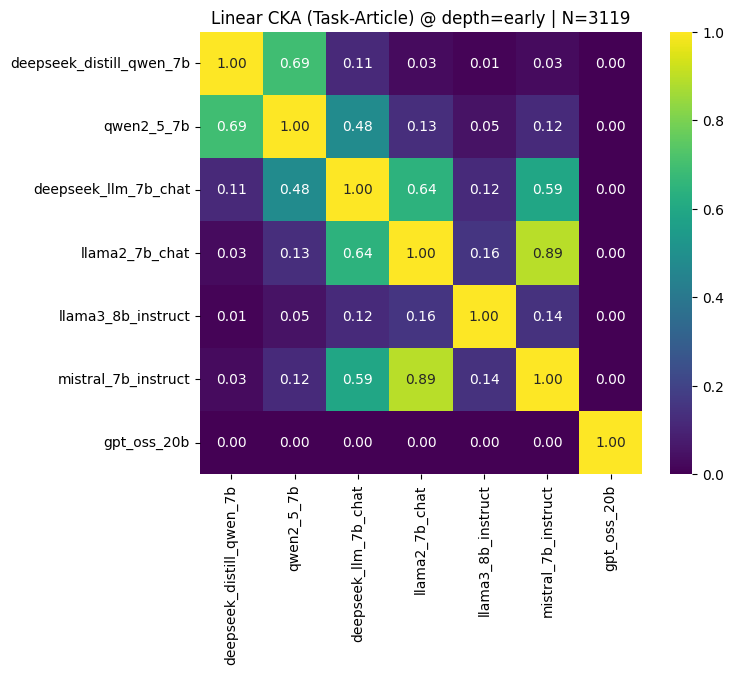

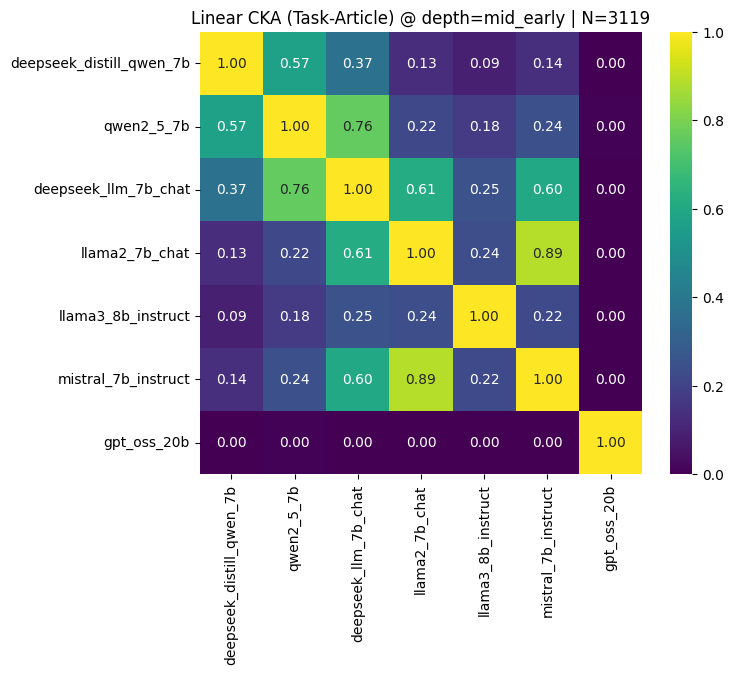

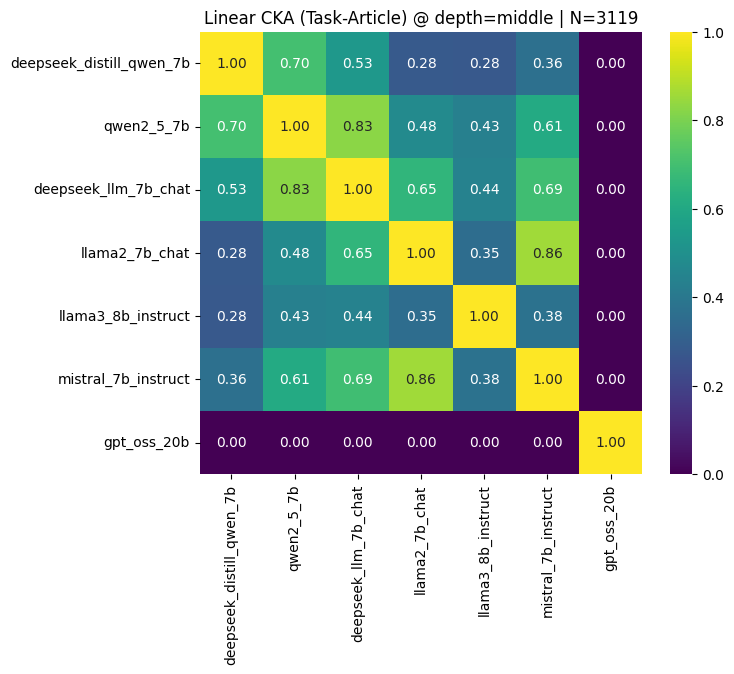

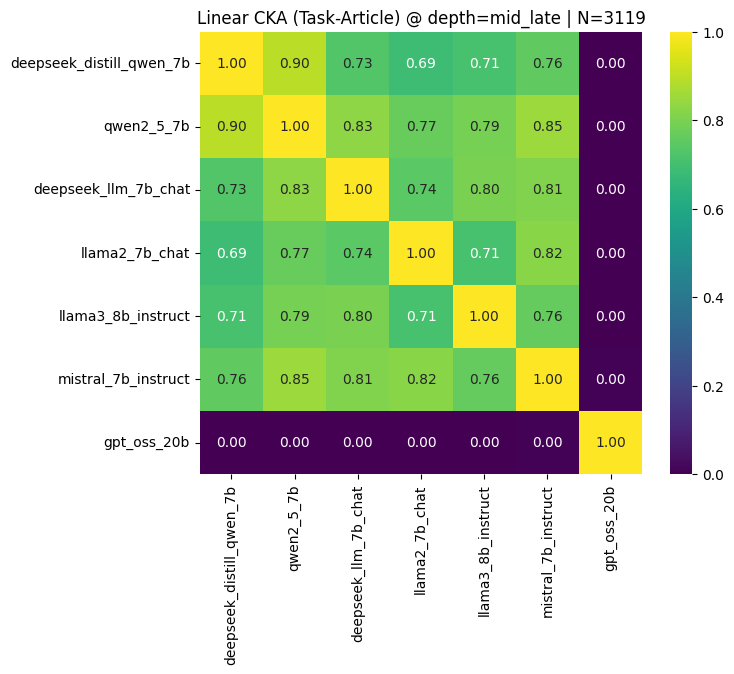

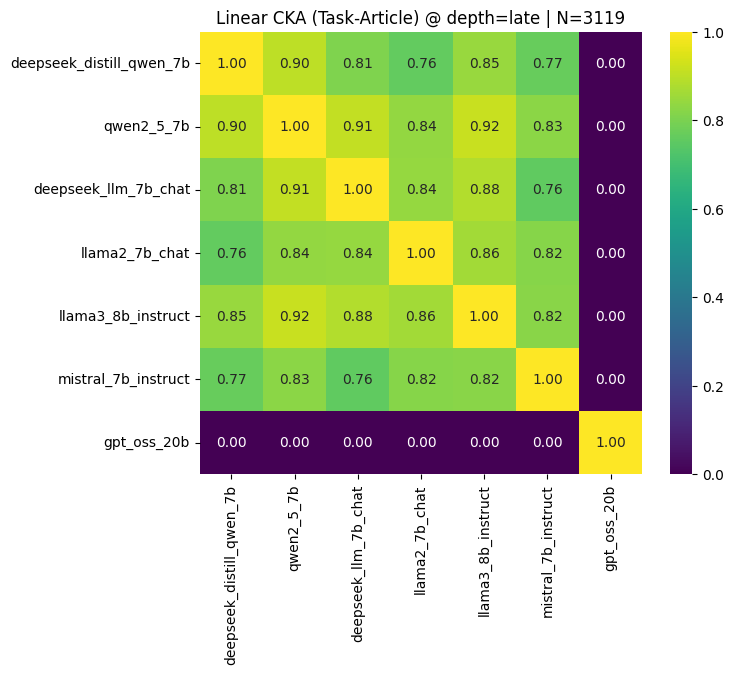

✅ Multi-depth Task-Article CKA done. Saved to: /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/CKA_Figures_TaskArticle_v2

Top CKA pairs at late depth:
qwen2_5_7b             vs llama3_8b_instruct    : 0.918
qwen2_5_7b             vs deepseek_llm_7b_chat  : 0.907
deepseek_distill_qwen_7b vs qwen2_5_7b            : 0.901
deepseek_llm_7b_chat   vs llama3_8b_instruct    : 0.883
llama2_7b_chat         vs llama3_8b_instruct    : 0.861
deepseek_distill_qwen_7b vs llama3_8b_instruct    : 0.847
deepseek_llm_7b_chat   vs llama2_7b_chat        : 0.841
qwen2_5_7b             vs llama2_7b_chat        : 0.839
qwen2_5_7b             vs mistral_7b_instruct   : 0.828
llama3_8b_instruct     vs mistral_7b_instruct   : 0.823


In [ ]:
# ============================================
# Linear CKA from saved embeddings (new pipeline)
# - loads embeddings from Embeddings_MultiDepth_Run/<tag>/
# - aligns samples by intersection of valid indices (ta_oom==False)
# - computes CKA per depth + saves CSV + heatmaps
# ============================================

import os, json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# 1) Paths
# ----------------------------
ROOT = "/content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity"
EMB_ROOT = os.path.join(ROOT, "Embeddings_MultiDepth_Run")
FIG_DIR = os.path.join(ROOT, "CKA_Figures_TaskArticle_v2")
os.makedirs(FIG_DIR, exist_ok=True)

depths = ["early", "mid_early", "middle", "mid_late", "late"]

# ----------------------------
# 2) Models (must match your tag folders)
#    Use the same tags you used in your run script.
# ----------------------------
MODELS = [
    "deepseek_distill_qwen_7b",
    "qwen2_5_7b",
    "deepseek_llm_7b_chat",
    "llama2_7b_chat",
    "llama3_8b_instruct",
    "mistral_7b_instruct",
    "gpt_oss_20b",   # keep or drop depending on analysis
]

# If you want to exclude GPT-OSS from main figures:
# EXCLUDE_FROM_MAIN = {"gpt_oss_20b"}  # set() to include all


# ----------------------------
# 3) Utilities
# ----------------------------
def load_npy(path: str) -> np.ndarray:
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    Z = np.load(path)
    return Z.astype(np.float32, copy=False)

def center_over_samples(X: np.ndarray) -> np.ndarray:
    # Center columns/features using sample mean
    return X - X.mean(axis=0, keepdims=True)

def linear_cka(X: np.ndarray, Y: np.ndarray, eps: float = 1e-8) -> float:
    """
    Linear CKA (feature-space):
    CKA(X,Y) = ||X^T Y||_F^2 / (||X^T X||_F * ||Y^T Y||_F)
    with X,Y centered over samples.
    X: (N, dx), Y: (N, dy)
    """
    Xc = center_over_samples(X)
    Yc = center_over_samples(Y)

    XtY = Xc.T @ Yc
    num = np.sum(XtY * XtY)

    XtX = Xc.T @ Xc
    YtY = Yc.T @ Yc
    den = np.sqrt(np.sum(XtX * XtX) * np.sum(YtY * YtY)) + eps
    return float(num / den)

def compute_cka_matrix(reps: dict) -> pd.DataFrame:
    names = list(reps.keys())
    M = len(names)
    mat = np.zeros((M, M), dtype=np.float32)

    for i in range(M):
        Xi = reps[names[i]]
        for j in range(i, M):
            Yj = reps[names[j]]
            val = linear_cka(Xi, Yj)
            mat[i, j] = val
            mat[j, i] = val

    return pd.DataFrame(mat, index=names, columns=names)

def plot_heatmap(df: pd.DataFrame, title: str, outpath: str, vmin=0.0, vmax=1.0):
    plt.figure(figsize=(7.8, 6.6))
    sns.heatmap(df, annot=True, fmt=".2f", cmap="viridis", square=True,
                vmin=vmin, vmax=vmax, cbar=True)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(outpath, dpi=300)
    plt.show()

def load_stats_for_model(tag: str) -> pd.DataFrame:
    p = os.path.join(EMB_ROOT, tag, f"stats_{tag}.csv")
    if not os.path.exists(p):
        raise FileNotFoundError(p)
    df = pd.read_csv(p)
    df["model_tag"] = tag
    return df

def get_valid_indices(stats_df: pd.DataFrame) -> np.ndarray:
    """
    Valid indices for Task-Article CKA:
    - ta_oom == False (or 0)
    - optionally also require finite ta_full_len
    """
    # some csv may store booleans as True/False or 0/1
    ta_oom = stats_df["ta_oom"]
    # robust boolean conversion
    if ta_oom.dtype != bool:
        ta_oom = ta_oom.astype(str).str.lower().isin(["true", "1", "yes"])
    valid = ~ta_oom

    # keep only rows with numeric lengths (avoid NaN)
    if "ta_full_len" in stats_df.columns:
        valid = valid & stats_df["ta_full_len"].notna()

    return stats_df.loc[valid, "i"].astype(int).values


# ----------------------------
# 4) Build intersection of valid indices (to ensure same samples)
# ----------------------------
stats_by_model = {tag: load_stats_for_model(tag) for tag in MODELS}

valid_idx_by_model = {tag: set(get_valid_indices(stats_by_model[tag])) for tag in MODELS}

# intersection across a chosen subset (e.g., exclude GPT-OSS)
models_main = [m for m in MODELS if m not in EXCLUDE_FROM_MAIN]

# Fix: Handle the case where models_main is empty
if not models_main:
    common_idx_main = set()
else:
    common_idx_main = set.intersection(*[valid_idx_by_model[m] for m in models_main])

print("Models (main):", models_main)
print("Common valid N (main):", len(common_idx_main))

# also compute common indices for ALL (if you want)
# Fix: Handle the case where MODELS is empty for common_idx_all
if not MODELS:
    common_idx_all = set()
else:
    common_idx_all = set.intersection(*[valid_idx_by_model[m] for m in MODELS])
print("Common valid N (all models):", len(common_idx_all))

# choose which index set to use for plots
USE_ALL_MODELS = False  # True -> include GPT-OSS, but N will be tiny (likely 7)
common_idx = sorted(list(common_idx_all if USE_ALL_MODELS else common_idx_main))

if len(common_idx) < 20:
    print("⚠️ Warning: common N is very small. Consider excluding models with heavy OOM (e.g., GPT-OSS) for main plots.")


# ----------------------------
# 5) Multi-depth Task-Article CKA
# ----------------------------
cka_by_depth = {}

for d in depths:
    reps = {}
    for tag in (MODELS if USE_ALL_MODELS else models_main):
        path = os.path.join(EMB_ROOT, tag, f"Z_{tag}_task_article_{d}.npy")
        Z = load_npy(path)

        # subset to common indices
        Z_sub = Z[common_idx, :]
        reps[tag] = Z_sub

    df_cka = compute_cka_matrix(reps)
    cka_by_depth[d] = df_cka

    # save csv
    df_cka.to_csv(os.path.join(FIG_DIR, f"CKA_TaskArticle_{d}.csv"))

    # plot
    outpath = os.path.join(FIG_DIR, f"CKA_TaskArticle_{d}.png")
    plot_heatmap(
        df_cka,
        title=f"Linear CKA (Task-Conditioned) @ depth={d} | N={len(common_idx)}",
        outpath=outpath
    )

print("✅ Multi-depth Task-Article CKA done. Saved to:", FIG_DIR)


# ----------------------------
# 6) Print top pairs for writing
# ----------------------------
def top_pairs(df: pd.DataFrame, k=10):
    names = df.index.tolist()
    pairs = []
    for i in range(len(names)):
        for j in range(i+1, len(names)):
            pairs.append((names[i], names[j], float(df.iloc[i, j])))
    pairs.sort(key=lambda x: x[2], reverse=True)
    return pairs[:k]

print("\nTop CKA pairs at late depth:")
for a,b,v in top_pairs(cka_by_depth["late"], k=10):
    print(f"{a:22s} vs {b:22s}: {v:.3f}")

Models used: ['deepseek_distill_qwen_7b', 'qwen2_5_7b', 'deepseek_llm_7b_chat', 'llama2_7b_chat', 'llama3_8b_instruct', 'mistral_7b_instruct', 'gpt_oss_20b']
Common valid N: 3119


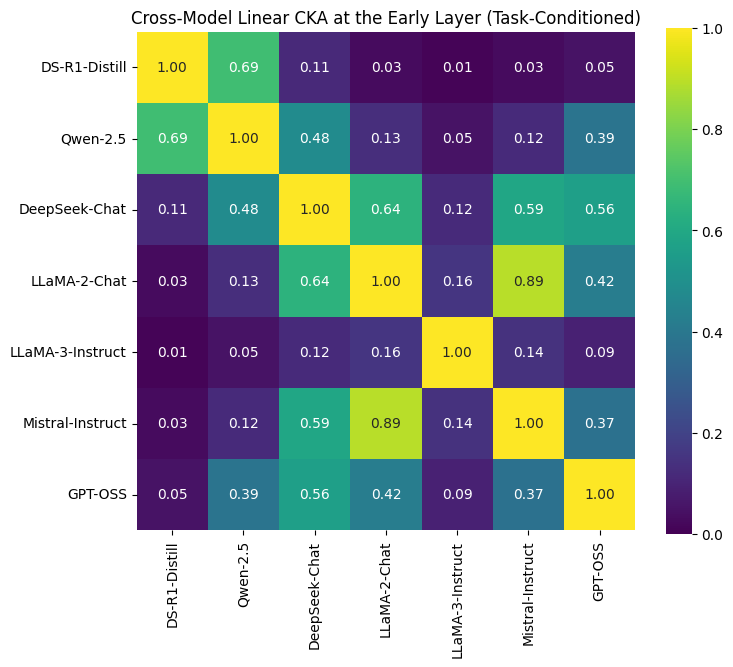

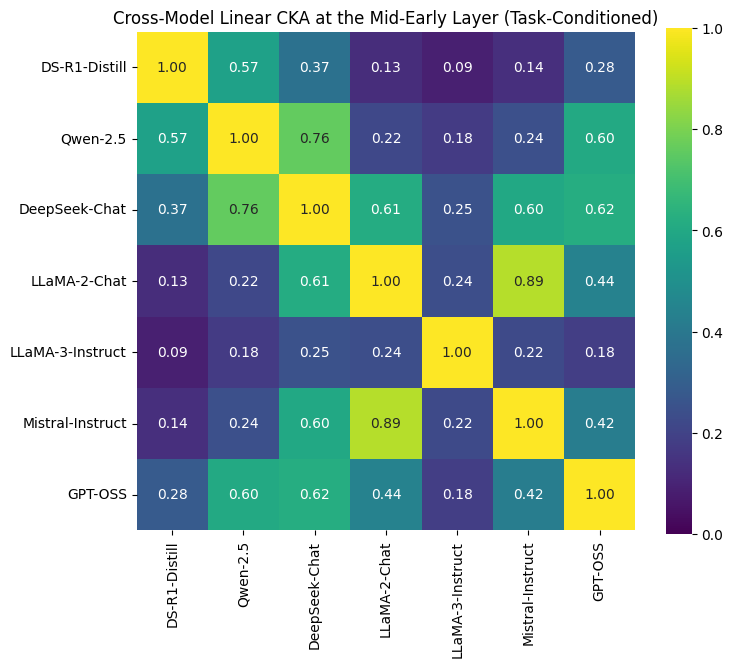

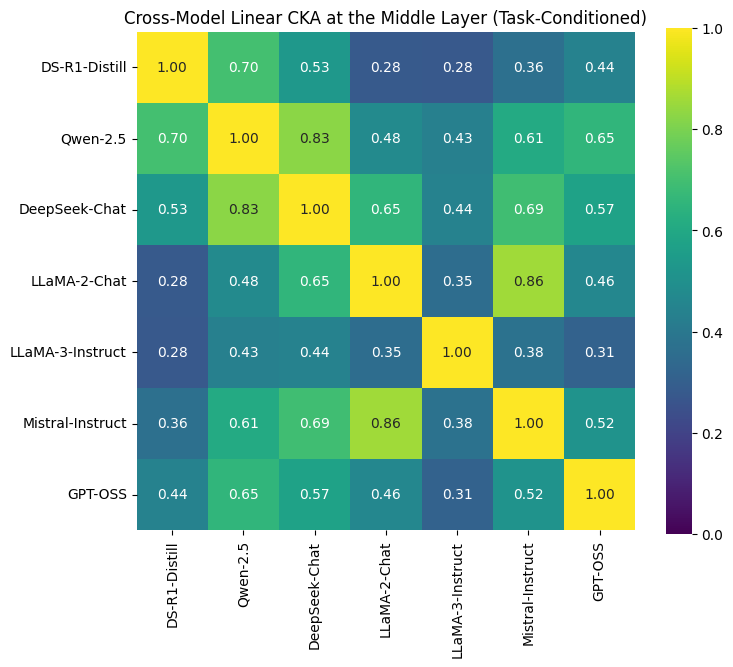

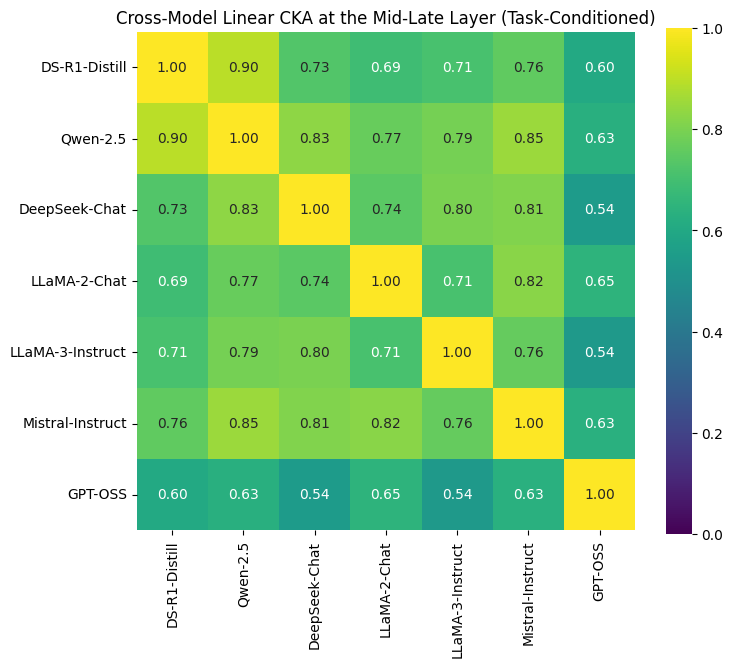

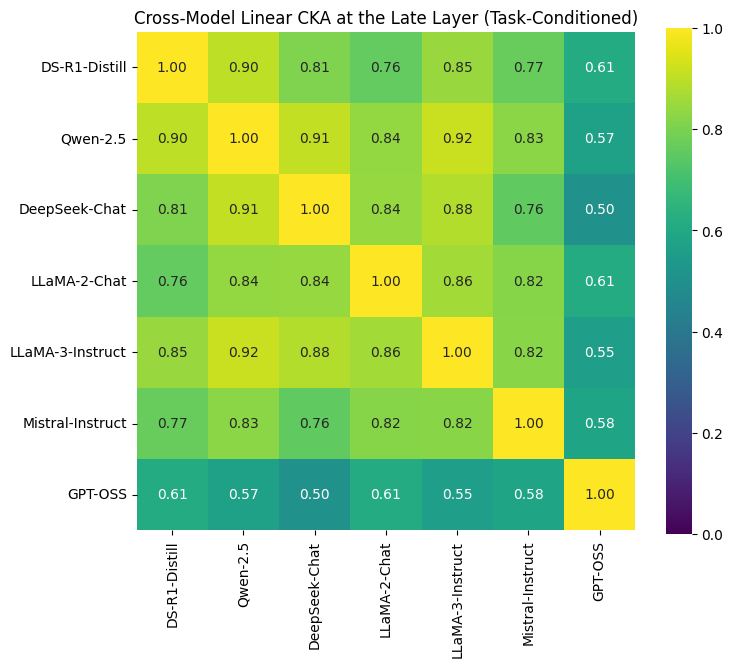

✅ Multi-depth Task-Article CKA finished.

Top CKA pairs at late depth:
Qwen-2.5             vs LLaMA-3-Instruct    : 0.918
Qwen-2.5             vs DeepSeek-Chat       : 0.907
DS-R1-Distill        vs Qwen-2.5            : 0.901
DeepSeek-Chat        vs LLaMA-3-Instruct    : 0.883
LLaMA-2-Chat         vs LLaMA-3-Instruct    : 0.861
DS-R1-Distill        vs LLaMA-3-Instruct    : 0.847
DeepSeek-Chat        vs LLaMA-2-Chat        : 0.841
Qwen-2.5             vs LLaMA-2-Chat        : 0.839
Qwen-2.5             vs Mistral-Instruct    : 0.828
LLaMA-3-Instruct     vs Mistral-Instruct    : 0.823


In [ ]:
# ============================================
# Linear CKA from saved embeddings (new pipeline)
# + GPT-OSS loaded from external path
# + Short display names (paper-ready)
# ============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# 1) Paths
# ----------------------------
ROOT = "/content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity"
EMB_ROOT = os.path.join(ROOT, "Embeddings_MultiDepth_Run")
FIG_DIR = os.path.join(ROOT, "CKA_Figures_TaskArticle_v2")
os.makedirs(FIG_DIR, exist_ok=True)

DEPTHS = ["early", "mid_early", "middle", "mid_late", "late"]

# ----------------------------
# 2) Models (internal tags)
# ----------------------------
MODELS = [
    "deepseek_distill_qwen_7b",
    "qwen2_5_7b",
    "deepseek_llm_7b_chat",
    "llama2_7b_chat",
    "llama3_8b_instruct",
    "mistral_7b_instruct",
    "gpt_oss_20b",
]

EXCLUDE_FROM_MAIN = set()
USE_ALL_MODELS = False

# ----------------------------
# 2.1) Display names (for figures & tables)
# ----------------------------
MODEL_DISPLAY_NAME = {
    "deepseek_distill_qwen_7b": "DS-R1-Distill",
    "qwen2_5_7b": "Qwen-2.5",
    "deepseek_llm_7b_chat": "DeepSeek-Chat",
    "llama2_7b_chat": "LLaMA-2-Chat",
    "llama3_8b_instruct": "LLaMA-3-Instruct",
    "mistral_7b_instruct": "Mistral-Instruct",
    "gpt_oss_20b": "GPT-OSS",
}

# ----------------------------
# 3) GPT-OSS external paths
# ----------------------------
GPTOSS_PATHS = {
    "task_article": f"{ROOT}/Outputs_GPTOSS_noChunk/GPT_OSS_task_article.npy"
}

# ----------------------------
# 4) Utilities
# ----------------------------
def load_npy(path: str) -> np.ndarray:
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    return np.load(path).astype(np.float32, copy=False)

def center_over_samples(X: np.ndarray) -> np.ndarray:
    return X - X.mean(axis=0, keepdims=True)

def linear_cka(X: np.ndarray, Y: np.ndarray, eps: float = 1e-8) -> float:
    Xc = center_over_samples(X)
    Yc = center_over_samples(Y)

    XtY = Xc.T @ Yc
    num = np.sum(XtY * XtY)

    XtX = Xc.T @ Xc
    YtY = Yc.T @ Yc
    den = np.sqrt(np.sum(XtX * XtX) * np.sum(YtY * YtY)) + eps
    return float(num / den)

def compute_cka_matrix(reps: dict, display_map: dict) -> pd.DataFrame:
    tags = list(reps.keys())
    names = [display_map.get(t, t) for t in tags]

    M = len(tags)
    mat = np.zeros((M, M), dtype=np.float32)

    for i in range(M):
        for j in range(i, M):
            v = linear_cka(reps[tags[i]], reps[tags[j]])
            mat[i, j] = mat[j, i] = v

    return pd.DataFrame(mat, index=names, columns=names)

def plot_heatmap(df, title, outpath, vmin=0.0, vmax=1.0):
    plt.figure(figsize=(7.8, 6.6))
    sns.heatmap(
        df, annot=True, fmt=".2f", cmap="viridis",
        square=True, vmin=vmin, vmax=vmax, cbar=True
    )
    plt.title(title)
    plt.tight_layout()
    plt.savefig(outpath, dpi=300)
    plt.show()

# ----------------------------
# 5) Stats + valid indices
# ----------------------------
def load_stats_for_model(tag: str) -> pd.DataFrame:
    p = os.path.join(EMB_ROOT, tag, f"stats_{tag}.csv")
    if not os.path.exists(p):
        raise FileNotFoundError(p)
    return pd.read_csv(p)

def get_valid_indices(stats_df: pd.DataFrame) -> np.ndarray:
    ta_oom = stats_df["ta_oom"]
    if ta_oom.dtype != bool:
        ta_oom = ta_oom.astype(str).str.lower().isin(["true", "1", "yes"])
    valid = ~ta_oom
    return stats_df.loc[valid, "i"].astype(int).values

stats_by_model = {m: load_stats_for_model(m) for m in MODELS}
valid_idx_by_model = {m: set(get_valid_indices(stats_by_model[m])) for m in MODELS}

models_main = [m for m in MODELS if m not in EXCLUDE_FROM_MAIN]

common_idx = set.intersection(
    *[valid_idx_by_model[m] for m in (MODELS if USE_ALL_MODELS else models_main)]
)
common_idx = sorted(list(common_idx))

print("Models used:", models_main if not USE_ALL_MODELS else MODELS)
print("Common valid N:", len(common_idx))

# ----------------------------
# 6) Unified embedding loader
# ----------------------------
def load_embedding(tag: str, depth: str, idx):
    if tag == "gpt_oss_20b":
        Z = load_npy(GPTOSS_PATHS["task_article"])
    else:
        Z = load_npy(
            os.path.join(EMB_ROOT, tag, f"Z_{tag}_task_article_{depth}.npy")
        )
    return Z[idx]

# ----------------------------
# 7) Multi-depth CKA
# ----------------------------
cka_by_depth = {}

for depth in DEPTHS:
    reps = {}
    for tag in (MODELS if USE_ALL_MODELS else models_main):
        reps[tag] = load_embedding(tag, depth, common_idx)

    df = compute_cka_matrix(reps, MODEL_DISPLAY_NAME)
    cka_by_depth[depth] = df

    df.to_csv(os.path.join(FIG_DIR, f"CKA_TaskArticle_{depth}.csv"))

    plot_heatmap(
        df,
        title=(
            f"Cross-Model Linear CKA at the "
            f"{depth.replace('_','-').title()} Layer "
            f"(Task-Conditioned)"
        ),
        outpath=os.path.join(FIG_DIR, f"CKA_TaskArticle_{depth}.png")
    )

print("✅ Multi-depth Task-Article CKA finished.")

# ----------------------------
# 8) Top pairs
# ----------------------------
def top_pairs(df, k=10):
    names = df.index.tolist()
    pairs = []
    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            pairs.append((names[i], names[j], float(df.iloc[i, j])))
    pairs.sort(key=lambda x: x[2], reverse=True)
    return pairs[:k]

print("\nTop CKA pairs at late depth:")
for a, b, v in top_pairs(cka_by_depth["late"], k=10):
    print(f"{a:20s} vs {b:20s}: {v:.3f}")

Models used: ['deepseek_distill_qwen_7b', 'qwen2_5_7b', 'deepseek_llm_7b_chat', 'llama2_7b_chat', 'llama3_8b_instruct', 'mistral_7b_instruct', 'gpt_oss_20b']
Common valid N: 3119


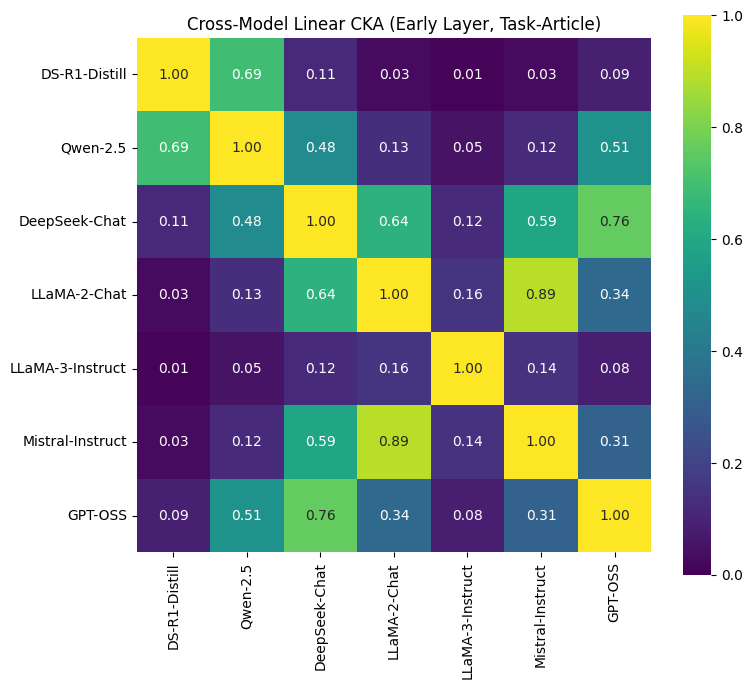

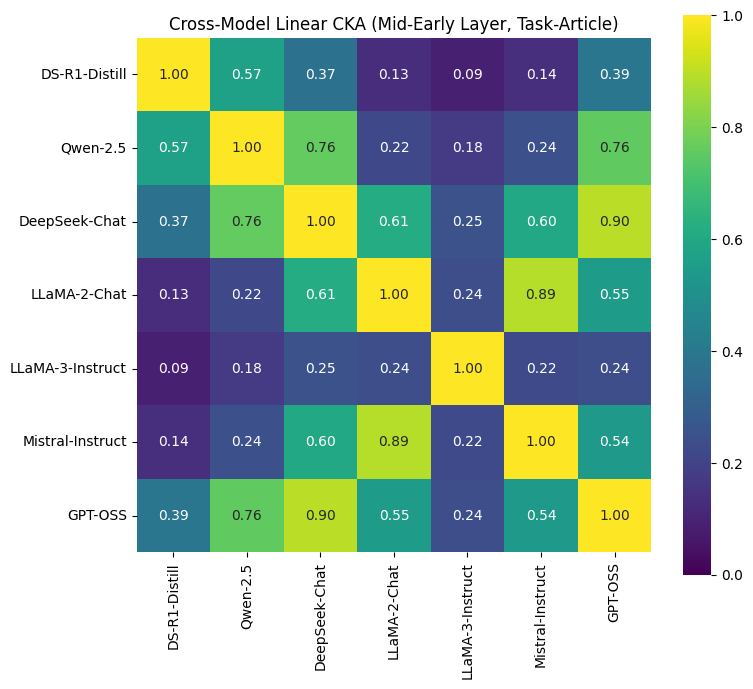

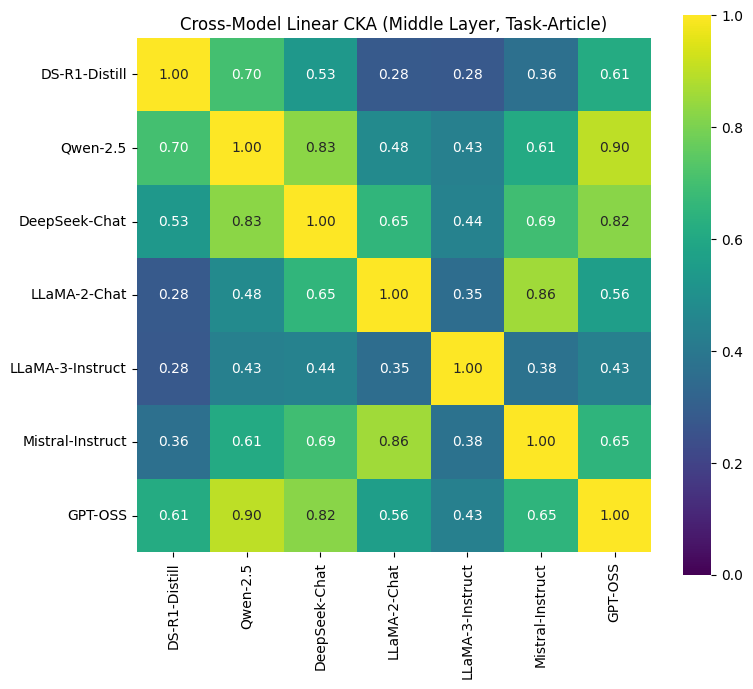

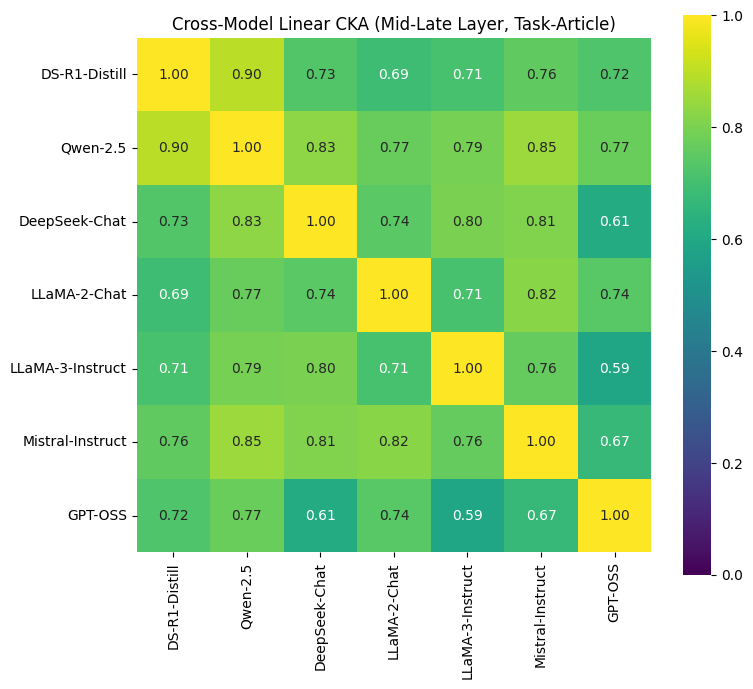

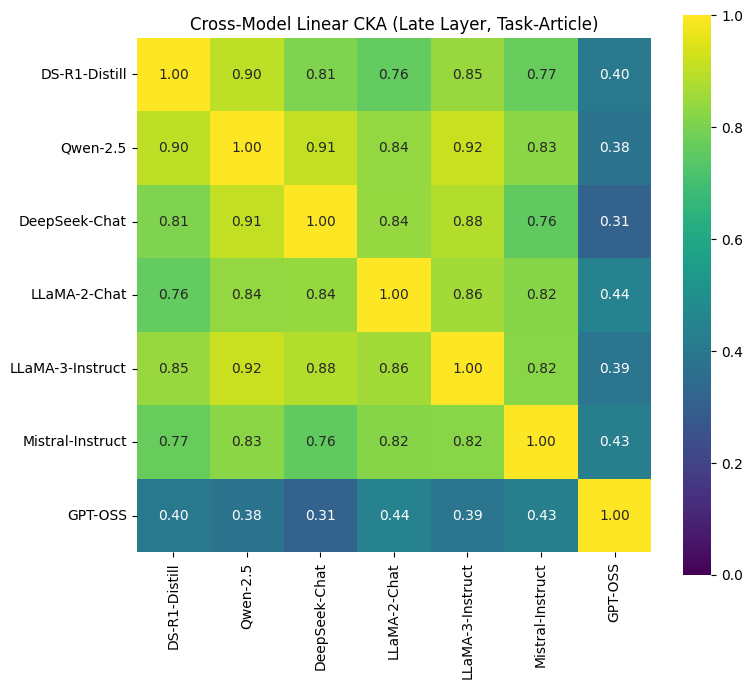

✅ DONE: Multi-depth Task-Article CKA

Top CKA pairs @ late depth:
Qwen-2.5                 vs LLaMA-3-Instruct        : 0.918
Qwen-2.5                 vs DeepSeek-Chat           : 0.907
DS-R1-Distill            vs Qwen-2.5                : 0.901
DeepSeek-Chat            vs LLaMA-3-Instruct        : 0.883
LLaMA-2-Chat             vs LLaMA-3-Instruct        : 0.861
DS-R1-Distill            vs LLaMA-3-Instruct        : 0.847
DeepSeek-Chat            vs LLaMA-2-Chat            : 0.841
Qwen-2.5                 vs LLaMA-2-Chat            : 0.839
Qwen-2.5                 vs Mistral-Instruct        : 0.828
LLaMA-3-Instruct         vs Mistral-Instruct        : 0.823


In [ ]:
# ============================================
# Linear CKA from saved embeddings
# - Task-Article
# - Multi-depth
# - GPT-OSS loaded from external folder (CORRECT)
# ============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# 1) PATHS
# ----------------------------
ROOT = "/content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity"

EMB_ROOT = os.path.join(ROOT, "Embeddings_MultiDepth_Run")
GPTOSS_ROOT = os.path.join(ROOT, "TaskConditioned_Embeds_MultiDepth_GPT-0SS")

FIG_DIR = os.path.join(ROOT, "CKA_Figures_TaskArticle_v2")
os.makedirs(FIG_DIR, exist_ok=True)

DEPTHS = ["early", "mid_early", "middle", "mid_late", "late"]

# ----------------------------
# 2) MODELS
# ----------------------------
MODELS = [
    "deepseek_distill_qwen_7b",
    "qwen2_5_7b",
    "deepseek_llm_7b_chat",
    "llama2_7b_chat",
    "llama3_8b_instruct",
    "mistral_7b_instruct",
    "gpt_oss_20b",
]

EXCLUDE_FROM_MAIN = set()
USE_ALL_MODELS = False

# ----------------------------
# 2.1) DISPLAY NAMES
# ----------------------------
MODEL_DISPLAY_NAME = {
    "deepseek_distill_qwen_7b": "DS-R1-Distill",
    "qwen2_5_7b": "Qwen-2.5",
    "deepseek_llm_7b_chat": "DeepSeek-Chat",
    "llama2_7b_chat": "LLaMA-2-Chat",
    "llama3_8b_instruct": "LLaMA-3-Instruct",
    "mistral_7b_instruct": "Mistral-Instruct",
    "gpt_oss_20b": "GPT-OSS",
}

# ----------------------------
# 3) BASIC UTILS
# ----------------------------
def load_npy(path):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    return np.load(path).astype(np.float32, copy=False)

def center(X):
    return X - X.mean(axis=0, keepdims=True)

def linear_cka(X, Y, eps=1e-8):
    Xc = center(X)
    Yc = center(Y)

    XtY = Xc.T @ Yc
    num = np.sum(XtY ** 2)

    XtX = Xc.T @ Xc
    YtY = Yc.T @ Yc
    den = np.sqrt(np.sum(XtX ** 2) * np.sum(YtY ** 2)) + eps

    return float(num / den)

def compute_cka_matrix(reps):
    tags = list(reps.keys())
    names = [MODEL_DISPLAY_NAME[t] for t in tags]

    M = len(tags)
    mat = np.zeros((M, M), dtype=np.float32)

    for i in range(M):
        for j in range(i, M):
            v = linear_cka(reps[tags[i]], reps[tags[j]])
            mat[i, j] = mat[j, i] = v

    return pd.DataFrame(mat, index=names, columns=names)

def plot_heatmap(df, title, outpath):
    plt.figure(figsize=(8, 7))
    sns.heatmap(
        df, annot=True, fmt=".2f",
        cmap="viridis", square=True,
        vmin=0.0, vmax=1.0, cbar=True
    )
    plt.title(title)
    plt.tight_layout()
    plt.savefig(outpath, dpi=300)
    plt.show()

# ----------------------------
# 4) LOAD STATS (Task-Article)
# ----------------------------
def load_stats(tag):
    path = os.path.join(EMB_ROOT, tag, f"stats_{tag}.csv")
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    return pd.read_csv(path)

def valid_indices_task_article(df):
    v = df["ta_oom"]
    if v.dtype != bool:
        v = v.astype(str).str.lower().isin(["true", "1", "yes"])
    return set(df.loc[~v, "i"].astype(int))

stats = {m: load_stats(m) for m in MODELS if m != "gpt_oss_20b"}
valid_idx = {m: valid_indices_task_article(stats[m]) for m in stats}

models_main = [m for m in MODELS if m not in EXCLUDE_FROM_MAIN and m != "gpt_oss_20b"]

common_idx = set.intersection(*[valid_idx[m] for m in models_main])
common_idx = sorted(common_idx)

print("Models used:", models_main + ["gpt_oss_20b"])
print("Common valid N:", len(common_idx))

# ----------------------------
# 5) LOAD EMBEDDINGS (TASK-ARTICLE)
# ----------------------------
def load_embedding(tag, depth, idx):
    if tag == "gpt_oss_20b":
        path = os.path.join(
            GPTOSS_ROOT,
            f"Z_GPT-0SS_task_article_{depth}.npy"
        )
    else:
        path = os.path.join(
            EMB_ROOT,
            tag,
            f"Z_{tag}_task_article_{depth}.npy"
        )

    Z = load_npy(path)
    return Z[idx]

# ----------------------------
# 6) MULTI-DEPTH CKA
# ----------------------------
cka_by_depth = {}

for depth in DEPTHS:
    reps = {}
    for tag in MODELS:
        reps[tag] = load_embedding(tag, depth, common_idx)

    df = compute_cka_matrix(reps)
    cka_by_depth[depth] = df

    df.to_csv(os.path.join(FIG_DIR, f"CKA_TaskArticle_{depth}.csv"))

    plot_heatmap(
        df,
        title=f"Cross-Model Linear CKA ({depth.replace('_','-').title()} Layer, Task-Article)",
        outpath=os.path.join(FIG_DIR, f"CKA_TaskArticle_{depth}.png")
    )

print("✅ DONE: Multi-depth Task-Article CKA")

# ----------------------------
# 7) TOP PAIRS (LATE)
# ----------------------------
def top_pairs(df, k=10):
    names = df.index.tolist()
    pairs = []
    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            pairs.append((names[i], names[j], float(df.iloc[i, j])))
    return sorted(pairs, key=lambda x: x[2], reverse=True)[:k]

print("\nTop CKA pairs @ late depth:")
for a, b, v in top_pairs(cka_by_depth["late"], 10):
    print(f"{a:24s} vs {b:24s}: {v:.3f}")


Models used: ['deepseek_distill_qwen_7b', 'qwen2_5_7b', 'deepseek_llm_7b_chat', 'llama2_7b_chat', 'llama3_8b_instruct', 'mistral_7b_instruct', 'gpt_oss_20b']
Common valid N: 3119


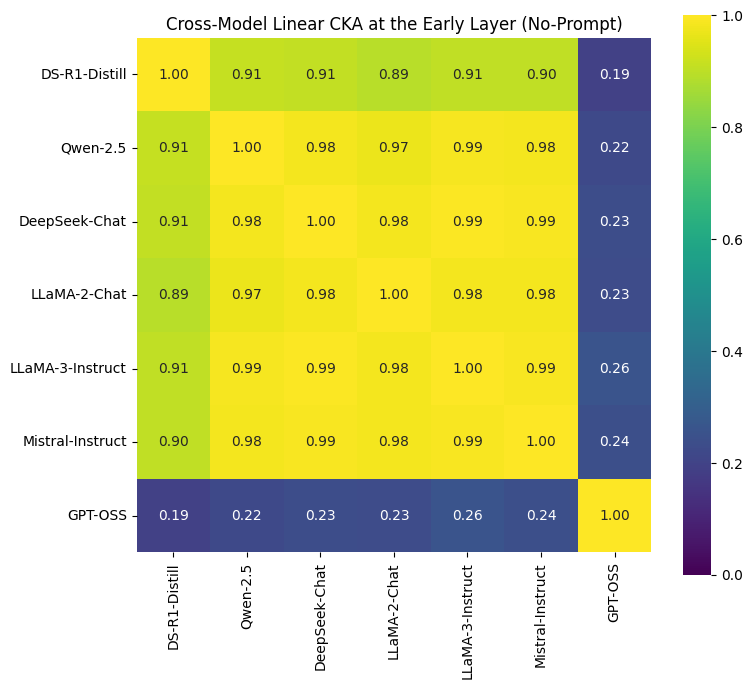

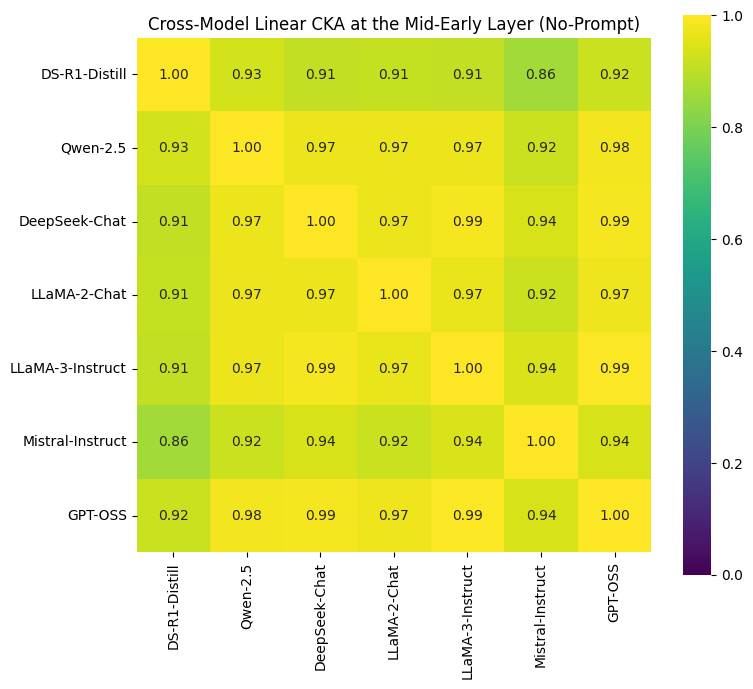

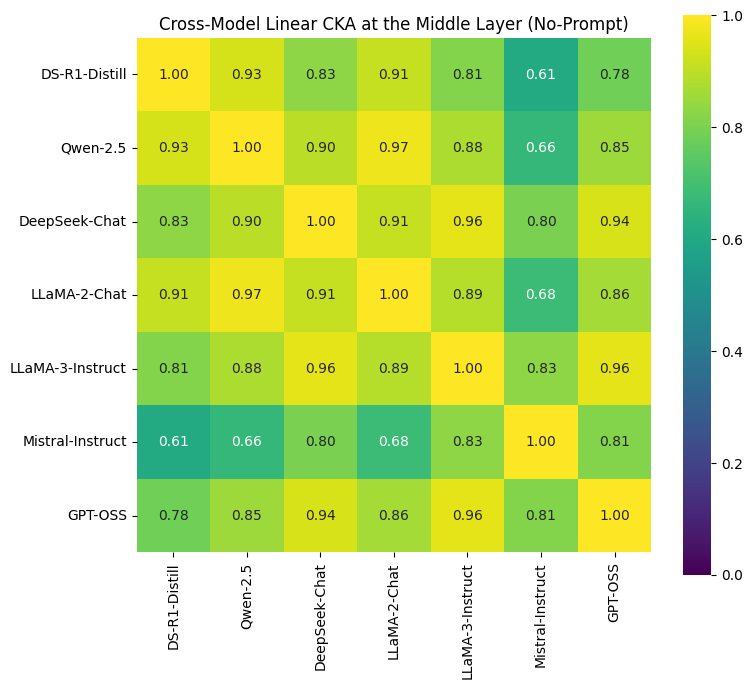

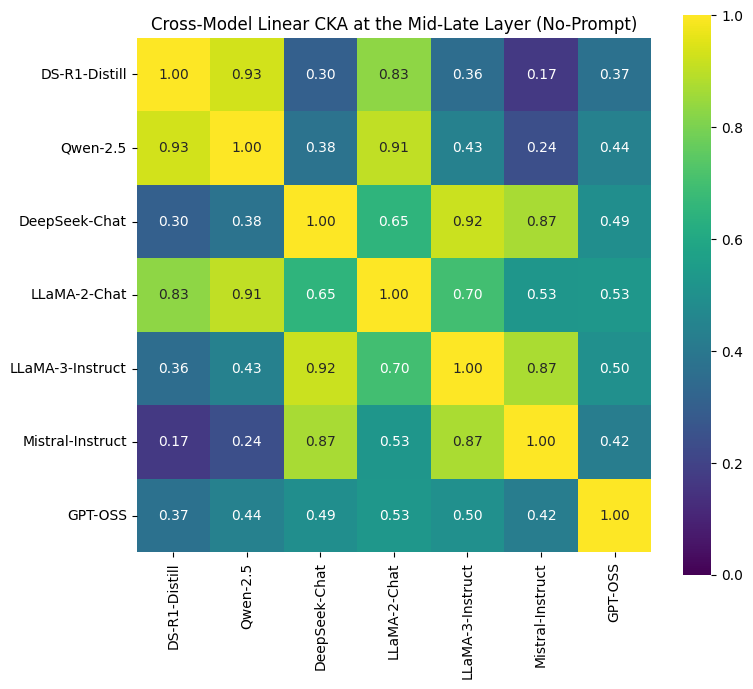

/tmp/ipython-input-1734809231.py:81: RuntimeWarning: overflow encountered in scalar multiply
  den = np.sqrt(np.sum(XtX * XtX) * np.sum(YtY * YtY)) + eps


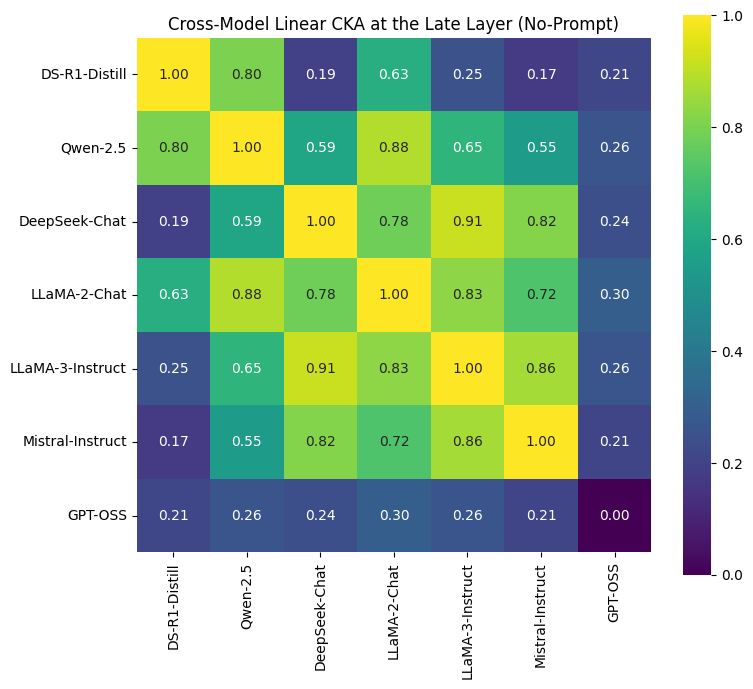

✅ DONE: Multi-depth NO-PROMPT CKA
Saved to: /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/CKA_Figures_NoPrompt

Top CKA pairs @ late depth:
DeepSeek-Chat            vs LLaMA-3-Instruct        : 0.915
Qwen-2.5                 vs LLaMA-2-Chat            : 0.884
LLaMA-3-Instruct         vs Mistral-Instruct        : 0.864
LLaMA-2-Chat             vs LLaMA-3-Instruct        : 0.832
DeepSeek-Chat            vs Mistral-Instruct        : 0.816
DS-R1-Distill            vs Qwen-2.5                : 0.803
DeepSeek-Chat            vs LLaMA-2-Chat            : 0.780
LLaMA-2-Chat             vs Mistral-Instruct        : 0.720
Qwen-2.5                 vs LLaMA-3-Instruct        : 0.651
DS-R1-Distill            vs LLaMA-2-Chat            : 0.625


In [ ]:
# ============================================
# Linear CKA — NO-PROMPT (Multi-depth)
# - Load per-depth noprompt embeddings
# - Align samples via intersection of valid indices
# - Special-case GPT-OSS embeddings from separate root
# - Save CSV + heatmaps
# ============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# 1) PATHS
# ----------------------------
ROOT = "/content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity"

EMB_ROOT_MAIN = os.path.join(ROOT, "Embeddings_MultiDepth_Run")
EMB_ROOT_GPTOSS = os.path.join(ROOT, "NoPrompt_Embeds_MultiDepth_GPT-OSS")

FIG_DIR = os.path.join(ROOT, "CKA_Figures_NoPrompt")
os.makedirs(FIG_DIR, exist_ok=True)

DEPTHS = ["early", "mid_early", "middle", "mid_late", "late"]

# ----------------------------
# 2) MODELS
# ----------------------------
MODELS = [
    "deepseek_distill_qwen_7b",
    "qwen2_5_7b",
    "deepseek_llm_7b_chat",
    "llama2_7b_chat",
    "llama3_8b_instruct",
    "mistral_7b_instruct",
    "gpt_oss_20b",
]
# 2.1) DISPLAY NAMES (for figures & tables)
# ----------------------------
MODEL_DISPLAY_NAME = {
    "deepseek_distill_qwen_7b": "DS-R1-Distill",
    "qwen2_5_7b": "Qwen-2.5",
    "deepseek_llm_7b_chat": "DeepSeek-Chat",
    "llama2_7b_chat": "LLaMA-2-Chat",
    "llama3_8b_instruct": "LLaMA-3-Instruct",
    "mistral_7b_instruct": "Mistral-Instruct",
    "gpt_oss_20b": "GPT-OSS",
}

# If you want to exclude GPT-OSS from main plots:
EXCLUDE_FROM_MAIN = set()          # or {"gpt_oss_20b"}

USE_ALL_MODELS = False             # True = include GPT-OSS in intersection

# ----------------------------
# 3) BASIC UTILS
# ----------------------------
def load_npy(path: str) -> np.ndarray:
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    return np.load(path).astype(np.float32, copy=False)

def center_over_samples(X: np.ndarray) -> np.ndarray:
    return X - X.mean(axis=0, keepdims=True)

def linear_cka(X: np.ndarray, Y: np.ndarray, eps: float = 1e-8) -> float:
    """
    Linear CKA (feature space)
    X,Y: (N, d)
    """
    Xc = center_over_samples(X)
    Yc = center_over_samples(Y)

    XtY = Xc.T @ Yc
    num = np.sum(XtY * XtY)

    XtX = Xc.T @ Xc
    YtY = Yc.T @ Yc
    den = np.sqrt(np.sum(XtX * XtX) * np.sum(YtY * YtY)) + eps
    return float(num / den)

def compute_cka_matrix(reps: dict, display_map: dict) -> pd.DataFrame:
    tags = list(reps.keys())
    names = [display_map.get(t, t) for t in tags]

    M = len(tags)
    mat = np.zeros((M, M), dtype=np.float32)

    for i in range(M):
        for j in range(i, M):
            v = linear_cka(reps[tags[i]], reps[tags[j]])
            mat[i, j] = v
            mat[j, i] = v

    return pd.DataFrame(mat, index=names, columns=names)

def plot_heatmap(df: pd.DataFrame, title: str, outpath: str):
    plt.figure(figsize=(8, 7))
    sns.heatmap(
        df,
        annot=True,
        fmt=".2f",
        cmap="viridis",
        square=True,
        vmin=0.0,
        vmax=1.0,
        cbar=True,
    )
    plt.title(title)
    plt.tight_layout()
    plt.savefig(outpath, dpi=300)
    plt.show()

# ----------------------------
# 4) STATS & VALID INDICES
# ----------------------------
def load_stats(tag: str) -> pd.DataFrame:
    if tag == "gpt_oss_20b":
        p = os.path.join(EMB_ROOT_MAIN, tag, f"stats_{tag}.csv")
    else:
        p = os.path.join(EMB_ROOT_MAIN, tag, f"stats_{tag}.csv")

    if not os.path.exists(p):
        raise FileNotFoundError(p)

    df = pd.read_csv(p)
    df["model_tag"] = tag
    return df

def get_valid_indices_noprompt(stats_df: pd.DataFrame) -> set:
    """
    Valid indices for NO-PROMPT:
    - np_oom == False
    """
    np_oom = stats_df["np_oom"]
    if np_oom.dtype != bool:
        np_oom = np_oom.astype(str).str.lower().isin(["true", "1", "yes"])

    valid = ~np_oom
    return set(stats_df.loc[valid, "i"].astype(int).values)

# ----------------------------
# 5) LOAD COMMON INDICES
# ----------------------------
stats_by_model = {tag: load_stats(tag) for tag in MODELS}
valid_idx_by_model = {
    tag: get_valid_indices_noprompt(stats_by_model[tag])
    for tag in MODELS
}

models_main = [m for m in MODELS if m not in EXCLUDE_FROM_MAIN]

if USE_ALL_MODELS:
    common_idx = set.intersection(*[valid_idx_by_model[m] for m in MODELS])
else:
    common_idx = set.intersection(*[valid_idx_by_model[m] for m in models_main])

common_idx = sorted(list(common_idx))

print("Models used:", models_main if not USE_ALL_MODELS else MODELS)
print("Common valid N:", len(common_idx))

if len(common_idx) < 20:
    print("⚠️ WARNING: very small N — CKA may be unstable")

# ----------------------------
# 6) LOAD NOPROMPT EMBEDDINGS (PER DEPTH)
# ----------------------------
def load_embedding_noprompt(tag: str, depth: str, idx: list):
    """
    Load noprompt embeddings.
    - Standard models: Z_<tag>_noprompt_<depth>.npy
    - GPT-OSS: Z_GPT-0SS_noprompt_<depth>.npy (special naming)
    """

    if tag == "gpt_oss_20b":
        # GPT-OSS special case (your exact filenames)
        path = os.path.join(
            ROOT,
            "NoPrompt_Embeds_MultiDepth_GPT-0SS",
            f"Z_GPT-0SS_noprompt_{depth}.npy"
        )
    else:
        path = os.path.join(
            EMB_ROOT_MAIN,
            tag,
            f"Z_{tag}_noprompt_{depth}.npy"
        )

    if not os.path.exists(path):
        raise FileNotFoundError(
            f"[Missing embedding]\n"
            f"  tag   = {tag}\n"
            f"  depth = {depth}\n"
            f"  path  = {path}"
        )

    Z = np.load(path).astype(np.float32, copy=False)
    return Z[idx]



# ----------------------------
# 7) MULTI-DEPTH CKA
# ----------------------------
cka_by_depth = {}

for depth in DEPTHS:
    reps = {}

    for tag in (MODELS if USE_ALL_MODELS else models_main):
        reps[tag] = load_embedding_noprompt(tag, depth, common_idx)

    df_cka = compute_cka_matrix(reps, MODEL_DISPLAY_NAME)

    cka_by_depth[depth] = df_cka

    # save CSV
    df_cka.to_csv(os.path.join(FIG_DIR, f"CKA_NoPrompt_{depth}.csv"))

    # plot
    plot_heatmap(
        df_cka,
        title = f"Cross-Model Linear CKA at the {depth.replace('_','-').title()} Layer (No-Prompt)",
        outpath=os.path.join(FIG_DIR, f"CKA_NoPrompt_{depth}.png")
    )

print("✅ DONE: Multi-depth NO-PROMPT CKA")
print("Saved to:", FIG_DIR)

# ----------------------------
# 8) TOP PAIRS (LATE DEPTH)
# ----------------------------
def top_pairs(df: pd.DataFrame, k=10):
    names = df.index.tolist()
    pairs = []
    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            pairs.append((names[i], names[j], float(df.iloc[i, j])))
    pairs.sort(key=lambda x: x[2], reverse=True)
    return pairs[:k]

print("\nTop CKA pairs @ late depth:")
for a, b, v in top_pairs(cka_by_depth["late"], k=10):
    print(f"{a:24s} vs {b:24s}: {v:.3f}")


# CROSS-LAYER CKA

/tmp/ipython-input-2017480069.py:57: RuntimeWarning: overflow encountered in scalar multiply
  np.sum((Xc.T @ Xc) ** 2) *


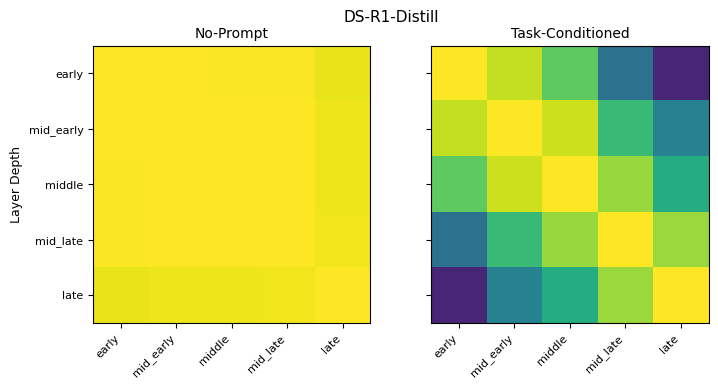

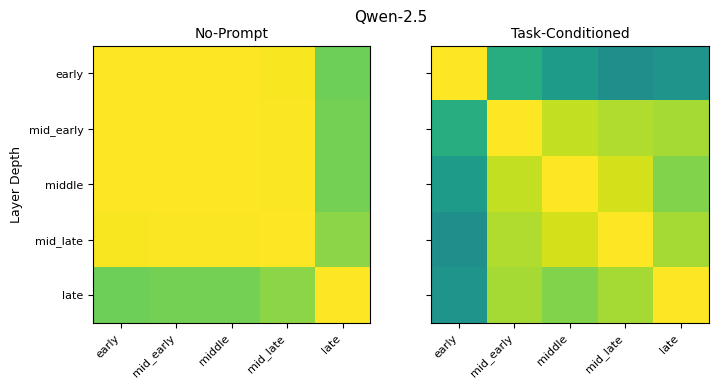

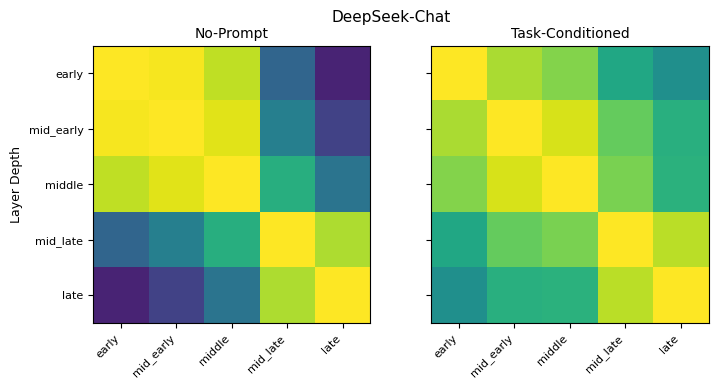

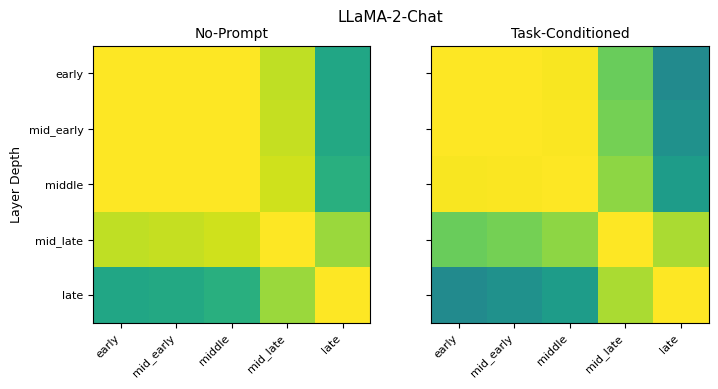

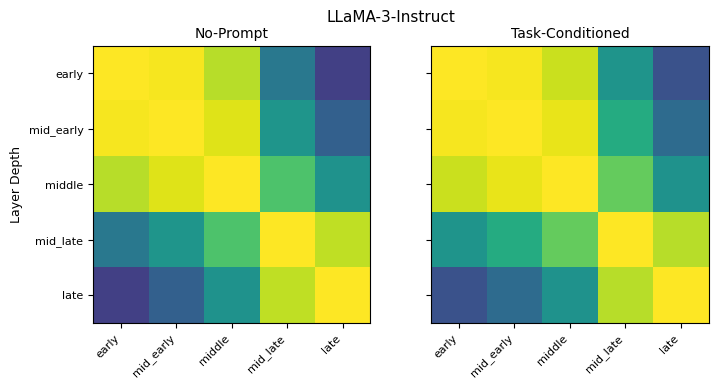

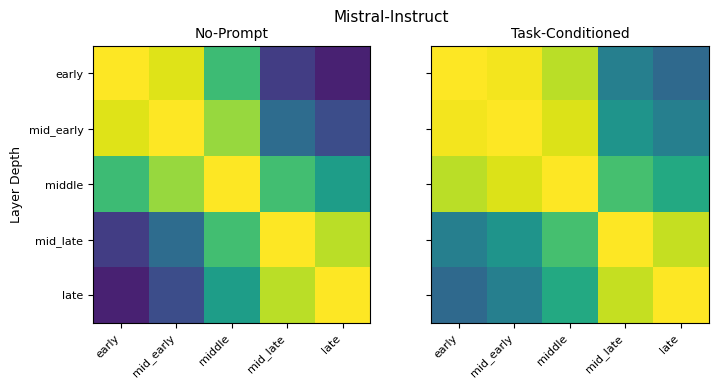

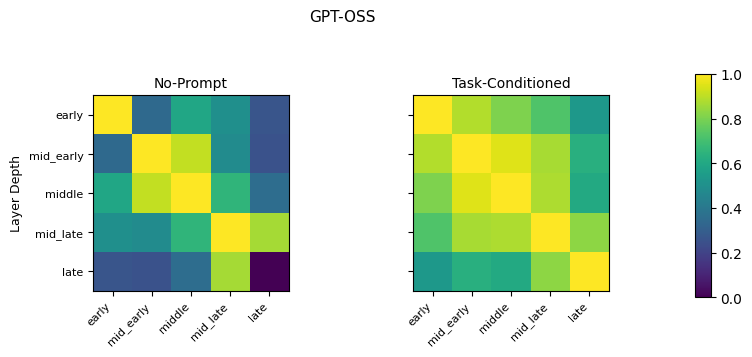

✅ DONE: Per-model Cross-Layer CKA (No-Prompt vs Task)


In [ ]:
# ============================================================
# Cross-Layer Linear CKA
# - Per-model (paper-ready)
# - No-Prompt vs Task-Conditioned
# - GPT-OSS handled correctly
# ============================================================

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# PATHS
# ----------------------------
ROOT = "/content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity"

EMB_ROOT_MAIN = os.path.join(ROOT, "Embeddings_MultiDepth_Run")
GPTOSS_NOPROMPT = os.path.join(ROOT, "NoPrompt_Embeds_MultiDepth_GPT-0SS")
GPTOSS_TASK = os.path.join(ROOT, "TaskConditioned_Embeds_MultiDepth_GPT-0SS")

FIG_DIR = os.path.join(ROOT, "CKA_Figures_PerModel")
os.makedirs(FIG_DIR, exist_ok=True)

DEPTHS = ["early", "mid_early", "middle", "mid_late", "late"]

MODELS = [
    "deepseek_distill_qwen_7b",
    "qwen2_5_7b",
    "deepseek_llm_7b_chat",
    "llama2_7b_chat",
    "llama3_8b_instruct",
    "mistral_7b_instruct",
    "gpt_oss_20b",
]

DISPLAY = {
    "deepseek_distill_qwen_7b": "DS-R1-Distill",
    "qwen2_5_7b": "Qwen-2.5",
    "deepseek_llm_7b_chat": "DeepSeek-Chat",
    "llama2_7b_chat": "LLaMA-2-Chat",
    "llama3_8b_instruct": "LLaMA-3-Instruct",
    "mistral_7b_instruct": "Mistral-Instruct",
    "gpt_oss_20b": "GPT-OSS",
}

# ----------------------------
# CKA
# ----------------------------
def center(X):
    return X - X.mean(axis=0, keepdims=True)

def linear_cka(X, Y, eps=1e-8):
    Xc, Yc = center(X), center(Y)
    num = np.sum((Xc.T @ Yc) ** 2)
    den = np.sqrt(
        np.sum((Xc.T @ Xc) ** 2) *
        np.sum((Yc.T @ Yc) ** 2)
    ) + eps
    return float(num / den)

# ----------------------------
# LOAD EMBEDDINGS
# ----------------------------
def load_embedding(model, depth, regime):
    if model == "gpt_oss_20b":
        if regime == "NoPrompt":
            path = os.path.join(GPTOSS_NOPROMPT, f"Z_GPT-0SS_noprompt_{depth}.npy")
        else:
            path = os.path.join(GPTOSS_TASK, f"Z_GPT-0SS_task_article_{depth}.npy")
    else:
        path = os.path.join(
            EMB_ROOT_MAIN,
            model,
            f"Z_{model}_{'noprompt' if regime=='NoPrompt' else 'task_article'}_{depth}.npy"
        )

    if not os.path.exists(path):
        raise FileNotFoundError(path)

    return np.load(path).astype(np.float32, copy=False)

# ----------------------------
# PER-MODEL CROSS-LAYER CKA
# ----------------------------
def cross_layer_cka(model, regime):
    reps = {d: load_embedding(model, d, regime) for d in DEPTHS}

    # align by min N
    N = min(Z.shape[0] for Z in reps.values())
    reps = {d: Z[:N] for d, Z in reps.items()}

    C = np.zeros((len(DEPTHS), len(DEPTHS)))
    for i, di in enumerate(DEPTHS):
        for j, dj in enumerate(DEPTHS):
            C[i, j] = linear_cka(reps[di], reps[dj])
    return C

# ----------------------------
# PLOT (PER MODEL)
# ----------------------------
for model in MODELS:
    fig, axes = plt.subplots(1, 2, figsize=(8, 3.6), sharex=True, sharey=True)

    for j, regime in enumerate(["NoPrompt", "Task"]):
        C = cross_layer_cka(model, regime)
        ax = axes[j]

        im = ax.imshow(C, vmin=0, vmax=1, cmap="viridis")

        ax.set_title(
            "No-Prompt" if regime == "NoPrompt" else "Task-Conditioned",
            fontsize=10
        )

        ax.set_xticks(range(len(DEPTHS)))
        ax.set_yticks(range(len(DEPTHS)))
        ax.set_xticklabels(DEPTHS, rotation=45, ha="right", fontsize=8)
        ax.set_yticklabels(DEPTHS, fontsize=8)

        if j == 0:
            ax.set_ylabel("Layer Depth", fontsize=9)

    fig.suptitle(DISPLAY[model], fontsize=11)

# vẽ xong axes rồi
plt.tight_layout(rect=[0, 0, 0.92, 0.92])

cax = fig.add_axes([0.94, 0.18, 0.02, 0.62])
fig.colorbar(im, cax=cax)

plt.savefig(out, dpi=300)
plt.show()

print("✅ DONE: Per-model Cross-Layer CKA (No-Prompt vs Task)")


/tmp/ipython-input-1443134432.py:44: RuntimeWarning: overflow encountered in scalar multiply
  np.sum((Xc.T @ Xc) ** 2) *


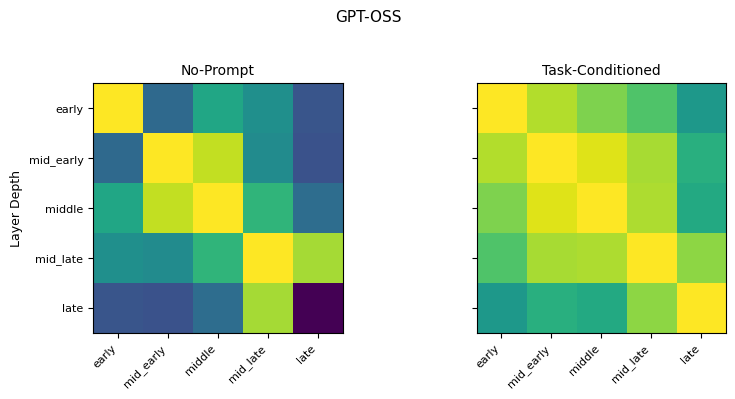

✅ DONE: GPT-OSS cross-layer CKA (no colorbar)


In [ ]:
# ============================================================
# GPT-OSS ONLY
# Cross-Layer Linear CKA
# - No-Prompt vs Task-Conditioned
# - NO colorbar (paper-ready)
# ============================================================

import os
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# 1) PATHS
# ----------------------------
ROOT = "/content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity"

GPT_NOPROMPT_ROOT = os.path.join(
    ROOT, "NoPrompt_Embeds_MultiDepth_GPT-0SS"
)
GPT_TASK_ROOT = os.path.join(
    ROOT, "TaskConditioned_Embeds_MultiDepth_GPT-0SS"
)

OUT_FIG = os.path.join(ROOT, "GPTOSS_CrossLayer_CKA.png")

DEPTHS = ["early", "mid_early", "middle", "mid_late", "late"]

# ----------------------------
# 2) BASIC UTILS
# ----------------------------
def load_npy(path):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    return np.load(path).astype(np.float32, copy=False)

def center(X):
    return X - X.mean(axis=0, keepdims=True)

def linear_cka(X, Y, eps=1e-8):
    Xc, Yc = center(X), center(Y)
    XtY = Xc.T @ Yc
    num = np.sum(XtY ** 2)
    den = np.sqrt(
        np.sum((Xc.T @ Xc) ** 2) *
        np.sum((Yc.T @ Yc) ** 2)
    ) + eps
    return float(num / den)

# ----------------------------
# 3) LOAD GPT-OSS EMBEDDINGS
# ----------------------------
def load_gptoss(depth, regime):
    if regime == "NoPrompt":
        path = os.path.join(
            GPT_NOPROMPT_ROOT,
            f"Z_GPT-0SS_noprompt_{depth}.npy"
        )
    else:
        path = os.path.join(
            GPT_TASK_ROOT,
            f"Z_GPT-0SS_task_article_{depth}.npy"
        )
    return load_npy(path)

# ----------------------------
# 4) CROSS-LAYER CKA
# ----------------------------
def cross_layer_cka(regime):
    reps = {
        d: load_gptoss(d, regime)
        for d in DEPTHS
    }

    C = np.zeros((len(DEPTHS), len(DEPTHS)))
    for i, di in enumerate(DEPTHS):
        for j, dj in enumerate(DEPTHS):
            C[i, j] = linear_cka(reps[di], reps[dj])
    return C

C_np = cross_layer_cka("NoPrompt")
C_ta = cross_layer_cka("Task")

# ----------------------------
# 5) PLOT (NO COLORBAR)
# ----------------------------
fig, axes = plt.subplots(
    1, 2,
    figsize=(8.6, 4),
    sharex=True,
    sharey=True
)

for ax, C, title in zip(
    axes,
    [C_np, C_ta],
    ["No-Prompt", "Task-Conditioned"]
):
    ax.imshow(C, vmin=0, vmax=1, cmap="viridis")

    ax.set_title(title, fontsize=10)
    ax.set_xticks(range(len(DEPTHS)))
    ax.set_yticks(range(len(DEPTHS)))
    ax.set_xticklabels(DEPTHS, rotation=45, ha="right", fontsize=8)
    ax.set_yticklabels(DEPTHS, fontsize=8)

axes[0].set_ylabel("Layer Depth", fontsize=9)

fig.suptitle("GPT-OSS", fontsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(OUT_FIG, dpi=300)
plt.show()

print("✅ DONE: GPT-OSS cross-layer CKA (no colorbar)")


# PAIR COMPARISON

In [ ]:
import os
import numpy as np

ROOT = "/content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity"

DEPTHS = ["early", "mid_early", "middle", "mid_late", "late"]

MODELS = [
    "deepseek_distill_qwen_7b",
    "qwen2_5_7b",
    "deepseek_llm_7b_chat",
    "llama2_7b_chat",
    "llama3_8b_instruct",
    "mistral_7b_instruct",
    "gpt_oss_20b",
]

# ----------------------------
# PATH MAP
# ----------------------------
EMB_ROOT_MAIN = os.path.join(ROOT, "Embeddings_MultiDepth_Run")

GPTOSS_NOPROMPT = os.path.join(ROOT, "NoPrompt_Embeds_MultiDepth_GPT-0SS")
GPTOSS_TASK = os.path.join(ROOT, "TaskConditioned_Embeds_MultiDepth_GPT-0SS")

# ----------------------------
# UTIL
# ----------------------------
def load_npy(path):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    return np.load(path).astype(np.float32, copy=False)

# ----------------------------
# 1) LOAD NO-PROMPT
# ----------------------------
emb_noprompt = {m: {} for m in MODELS}
N_ref = None

for m in MODELS:
    for d in DEPTHS:
        if m == "gpt_oss_20b":
            path = os.path.join(GPTOSS_NOPROMPT, f"Z_GPT-0SS_noprompt_{d}.npy")
        else:
            path = os.path.join(
                EMB_ROOT_MAIN, m, f"Z_{m}_noprompt_{d}.npy"
            )

        Z = load_npy(path)

        if N_ref is None:
            N_ref = Z.shape[0]
        else:
            assert Z.shape[0] == N_ref, f"N mismatch at {m}-{d}"

        emb_noprompt[m][d] = Z
        print("[NoPrompt]", m, d, Z.shape)

print("✔ No-Prompt loaded | N =", N_ref)

# ----------------------------
# 2) LOAD TASK-CONDITIONED (ARTICLE)
# ----------------------------
emb_task = {m: {} for m in MODELS}

for m in MODELS:
    for d in DEPTHS:
        if m == "gpt_oss_20b":
            path = os.path.join(GPTOSS_TASK, f"Z_GPT-0SS_task_article_{d}.npy")
        else:
            path = os.path.join(
                EMB_ROOT_MAIN, m, f"Z_{m}_task_article_{d}.npy"
            )

        Z = load_npy(path)
        assert Z.shape[0] == N_ref, f"N mismatch at {m}-{d}"

        emb_task[m][d] = Z
        print("[Task]", m, d, Z.shape)

print("\n✅ DONE: Loaded all embeddings (No-Prompt & Task-Conditioned)")


[NoPrompt] deepseek_distill_qwen_7b early (3119, 3584)
[NoPrompt] deepseek_distill_qwen_7b mid_early (3119, 3584)
[NoPrompt] deepseek_distill_qwen_7b middle (3119, 3584)
[NoPrompt] deepseek_distill_qwen_7b mid_late (3119, 3584)
[NoPrompt] deepseek_distill_qwen_7b late (3119, 3584)
[NoPrompt] qwen2_5_7b early (3119, 3584)
[NoPrompt] qwen2_5_7b mid_early (3119, 3584)
[NoPrompt] qwen2_5_7b middle (3119, 3584)
[NoPrompt] qwen2_5_7b mid_late (3119, 3584)
[NoPrompt] qwen2_5_7b late (3119, 3584)
[NoPrompt] deepseek_llm_7b_chat early (3119, 4096)
[NoPrompt] deepseek_llm_7b_chat mid_early (3119, 4096)
[NoPrompt] deepseek_llm_7b_chat middle (3119, 4096)
[NoPrompt] deepseek_llm_7b_chat mid_late (3119, 4096)
[NoPrompt] deepseek_llm_7b_chat late (3119, 4096)
[NoPrompt] llama2_7b_chat early (3119, 4096)
[NoPrompt] llama2_7b_chat mid_early (3119, 4096)
[NoPrompt] llama2_7b_chat middle (3119, 4096)
[NoPrompt] llama2_7b_chat mid_late (3119, 4096)
[NoPrompt] llama2_7b_chat late (3119, 4096)
[NoPrompt] l

In [ ]:
import numpy as np

def center(X):
    return X - X.mean(axis=0, keepdims=True)

def linear_cka(X, Y, eps=1e-8):
    Xc, Yc = center(X), center(Y)
    XtY = Xc.T @ Yc
    num = np.sum(XtY ** 2)
    den = np.sqrt(
        np.sum((Xc.T @ Xc) ** 2) *
        np.sum((Yc.T @ Yc) ** 2)
    ) + eps
    return float(num / den)


In [ ]:
import pandas as pd

def compute_anchor_cka(
    emb_dict,          # emb_task hoặc emb_noprompt
    models,
    depths,
    anchor_model
):
    rows = []

    for d in depths:
        Z_anchor = emb_dict[anchor_model][d]

        for m in models:
            if m == anchor_model:
                continue

            Z_other = emb_dict[m][d]
            cka = linear_cka(Z_anchor, Z_other)

            rows.append({
                "anchor": anchor_model,
                "other_model": m,
                "depth": d,
                "cka": cka
            })

    return pd.DataFrame(rows)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_anchor_heatmap(
    df,
    depths,
    display_name=None,
    title_suffix=""
):
    df["depth"] = pd.Categorical(df["depth"], categories=depths, ordered=True)

    pivot = df.pivot_table(
        index="other_model",
        columns="depth",
        values="cka",
        aggfunc="mean"
    )

    plt.figure(figsize=(6, 3 + 0.4 * len(pivot)))
    sns.heatmap(
        pivot,
        vmin=0.0, vmax=1.0,
        cmap="viridis",
        annot=True, fmt=".2f"
    )

    title = f"{display_name or df['anchor'].iloc[0]} vs others"
    if title_suffix:
        title += f" ({title_suffix})"

    plt.title(title)
    plt.xlabel("Depth")
    plt.ylabel("Other model")
    plt.tight_layout()
    plt.show()


## DS-Distill-Qwen

### Task-conditioned

/tmp/ipython-input-4089692220.py:12: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(


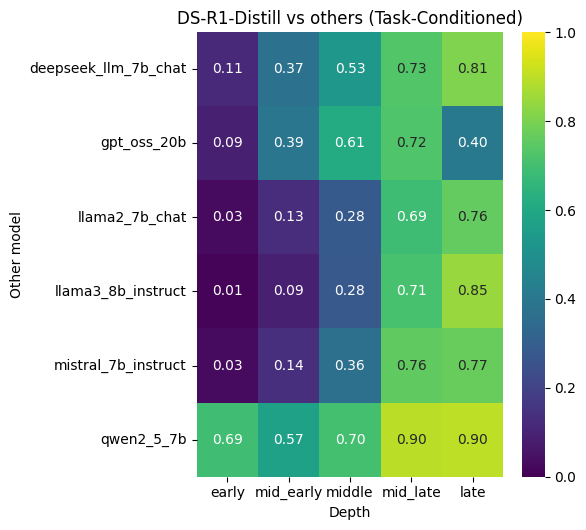

In [ ]:
anchor = "deepseek_distill_qwen_7b"

df_task_anchor = compute_anchor_cka(
    emb_task,
    MODELS,
    DEPTHS,
    anchor
)

plot_anchor_heatmap(
    df_task_anchor,
    DEPTHS,
    display_name="DS-R1-Distill",
    title_suffix="Task-Conditioned"
)


### No-Prompt

/tmp/ipython-input-4089692220.py:12: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(


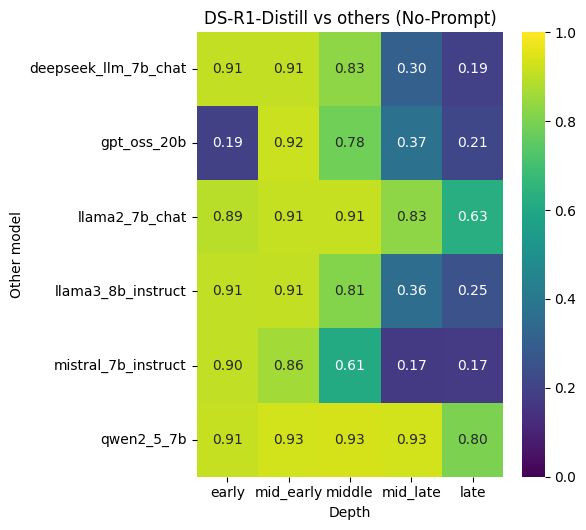

In [ ]:
df_np_anchor = compute_anchor_cka(
    emb_noprompt,
    MODELS,
    DEPTHS,
    anchor
)

plot_anchor_heatmap(
    df_np_anchor,
    DEPTHS,
    display_name="DS-R1-Distill",
    title_suffix="No-Prompt"
)


## GPT-OSS

/tmp/ipython-input-4089692220.py:12: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(


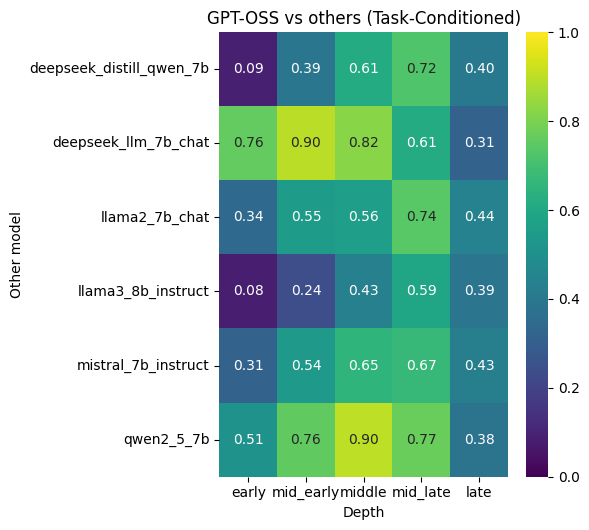

In [ ]:
anchor = "gpt_oss_20b"

df_task_anchor = compute_anchor_cka(
    emb_task,
    MODELS,
    DEPTHS,
    anchor
)

plot_anchor_heatmap(
    df_task_anchor,
    DEPTHS,
    display_name="GPT-OSS",
    title_suffix="Task-Conditioned"
)


/tmp/ipython-input-4089692220.py:12: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(


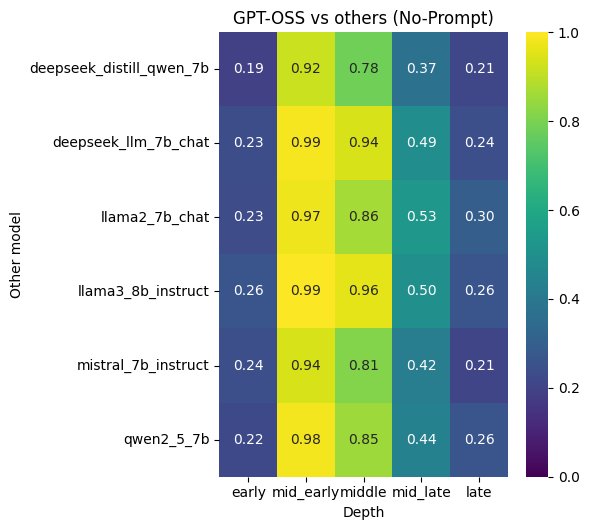

In [ ]:
df_np_anchor = compute_anchor_cka(
    emb_noprompt,
    MODELS,
    DEPTHS,
    anchor
)

plot_anchor_heatmap(
    df_np_anchor,
    DEPTHS,
    display_name="GPT-OSS",
    title_suffix="No-Prompt"
)
